# **Sprint 0 - Setup**

## 1. Configuración Inicial - Setup

In [1]:
# Importar librerías necesarias para el proceso
import os, sys, json, time, shutil, random
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ML
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# CV / PIL / OpenCV
from PIL import Image
import cv2

In [4]:
# scikit-learn metrics
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    cohen_kappa_score, balanced_accuracy_score,
    matthews_corrcoef
)

In [5]:
# Mostrar device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# ---------------------------
# CONFIG - ajusta rutas si hace falta
# ---------------------------
DATA_ROOT = '/content/sicapv2_data'    # cambiar si es necesario
# Sprint 0 artifacts
IMAGES_DIR = os.path.join(DATA_ROOT , 'SICAPv2', 'images')
MASKS_DIR  = os.path.join(DATA_ROOT , 'SICAPv2', 'masks')
LABELS_XLSX = os.path.join(DATA_ROOT , 'SICAPv2', 'wsi_labels.xlsx')
MANIFEST_CSV = os.path.join(DATA_ROOT ,'dataset_manifest.csv')

print("Rutas configuradas:")
print(" ROOT:", DATA_ROOT )
print(" IMAGES_DIR:", IMAGES_DIR)
print(" MASKS_DIR:", MASKS_DIR)
print(" LABELS_XLSX:", LABELS_XLSX)
print(" MANIFEST_CSV:", MANIFEST_CSV)

Rutas configuradas:
 ROOT: /content/sicapv2_data
 IMAGES_DIR: /content/sicapv2_data/SICAPv2/images
 MASKS_DIR: /content/sicapv2_data/SICAPv2/masks
 LABELS_XLSX: /content/sicapv2_data/SICAPv2/wsi_labels.xlsx
 MANIFEST_CSV: /content/sicapv2_data/dataset_manifest.csv


In [7]:
# Sprint1 processed
PROCESSED_BASE = os.path.join(DATA_ROOT , 'processed_patches', 'v1')
PROCESSED_MANIFEST = os.path.join(PROCESSED_BASE, 'dataset_manifest_processed.csv')
PROCESSED_IMAGES = os.path.join(PROCESSED_BASE, 'images')

In [8]:
# Sprint2 embeddings
EMBEDDINGS_DIR = os.path.join(PROCESSED_BASE, 'embeddings')

In [9]:
# Sprint3 outputs
MIL_OUTPUT_DIR = os.path.join(DATA_ROOT , 'MIL_dataset')
os.makedirs(MIL_OUTPUT_DIR, exist_ok=True)

In [10]:
# reproducibility
RND = 42
np.random.seed(RND)
random.seed(RND)
torch.manual_seed(RND)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RND)

### UTILS

In [11]:
# Utilities: parsing filenames, tissue fraction, safe load npy, label mapping helpers.
import re, hashlib, subprocess

In [12]:
def parse_filename(fn):
    """Extrae slide_id, x_ini, y_ini a partir del nombre del parche.
       Asume formato con '_Block' y '_xini_..._yini_...' (ajustar si es distinto)"""
    basename = os.path.basename(fn)
    m_slide = re.match(r'^([^_]+)_Block', basename)
    slide_id = m_slide.group(1) if m_slide else basename.split('_')[0]
    m = re.search(r'_xini_(\d+)_yini_(\d+)', basename)
    x_ini, y_ini = (int(m.group(1)), int(m.group(2))) if m else (None, None)
    return slide_id, x_ini, y_ini

In [13]:
def tissueFractionForImage(pil_img, downscale=256, sat_thr=20, val_thr=250):
    arr = np.array(pil_img.convert('RGB'))
    h,w = arr.shape[:2]
    scale = max(1, int(max(h,w)/downscale))
    small = cv2.resize(arr, (max(1,w//scale), max(1,h//scale)), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(small, cv2.COLOR_RGB2HSV)
    s, v = hsv[:,:,1], hsv[:,:,2]
    tissueMask = (s > sat_thr) & (v < val_thr)
    return float(tissueMask.mean())


In [14]:
def safe_load_npy(path):
    """Carga .npy robustamente y devuelve vector 1-D"""
    x = np.load(path)
    if x.ndim == 0:
        return np.array([x]).astype(np.float32)
    if x.ndim > 1:
        x = x.squeeze()
    if x.ndim == 1:
        return x.astype(np.float32)
    # fallback flatten
    return x.reshape(-1).astype(np.float32)

In [15]:
def get_git_hash():
    try:
        return subprocess.check_output(['git','rev-parse','--short','HEAD']).decode().strip()
    except Exception:
        return None

In [16]:
# Label remapping (consistent)
LABEL_MAP = {0:0, 3:1, 4:2, 5:3}
def map_label_to_class(raw_label):
    try:
        return LABEL_MAP[int(raw_label)]
    except Exception:
        return None


## 1.1 Verificar espacio disponible

In [17]:
# Verificar el espacio disponible en el disco local de Colab
!df -h /content

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   39G   75G  35% /


## 2. Descarga del Conjunto de Datos


In [18]:
ZIP_MAIN = "/content/sicapv2.zip"

if not os.path.exists(ZIP_MAIN):
    print("Archivo ZIP principal NO existe. Descargando...")

    # Enlace de descarga para el archivo ZIP
    download_url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9xxm58dvs3-2.zip"

    # Descargar el archivo ZIP y guardarlo como sicapv2.zip
    !wget -O $ZIP_MAIN $download_url
else:
    print("Archivo ZIP principal ya existe → NO se descarga.")


Archivo ZIP principal NO existe. Descargando...
--2026-01-02 19:43:38--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9xxm58dvs3-2.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.69.253, 52.92.34.66, 3.5.68.106, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.69.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2153353595 (2.0G) [application/zip]
Saving to: ‘/content/sicapv2.zip’

/content/sicapv2.zi 100%[===================>]   2.00G  18.6MB/s    in 1m 52s  

2026-01-02 19:45:32 (18.3 MB/s) - ‘/content/sicapv2.zip’ saved [2153353595/2153353595]



## 3. Descomprimir el Archivo ZIP principal


In [19]:
INTERMEDIATE_DIR = "/content/intermediate_data"

if not os.path.exists(INTERMEDIATE_DIR):
    print("Descomprimiendo ZIP principal...")

    # Crear un directorio para los archivos extraídos
    !mkdir /content/intermediate_data

    # Descomprimir el archivo principal en el directorio intermedio
    !unzip -q $ZIP_MAIN -d $INTERMEDIATE_DIR
else:
    print("Carpeta intermedia ya existe → NO se vuelve a descomprimir.")

Descomprimiendo ZIP principal...


In [20]:
# Listar los contenidos para verificar
!ls /content/intermediate_data

'SICAPv2 - Prostate Whole Slide Images with Gleason Grades Annotations'


## 4. Descomprimir el Archivo ZIP Anidado (SICAPv2.zip)

####"/content/intermediate_data/SICAPv2.../SICAPv2.zip"

In [21]:
# Ruta al archivo ZIP anidado
nested_zip = "/content/intermediate_data/SICAPv2 - Prostate Whole Slide Images with Gleason Grades Annotations/SICAPv2.zip"

# Define the target directory for the nested zip content
TARGET_SICAPV2_DIR = os.path.join(DATA_ROOT, 'SICAPv2')

# Check if the target extracted directory exists, not just ROOT
if not os.path.exists(TARGET_SICAPV2_DIR):
    print("Descomprimiendo ZIP anidado de SICAPv2...")

    # Crear un directorio para el resultado final
    os.makedirs(TARGET_SICAPV2_DIR, exist_ok=True)

    # Descomprimir el archivo anidado en el directorio final
    # Assuming SICAPv2.zip directly contains 'SICAPv2' folder, so unzip to ROOT
    !unzip -q "$nested_zip" -d $DATA_ROOT
else:
    print("SICAPv2 ya existe en disco → NO se descomprime nuevamente.")


Descomprimiendo ZIP anidado de SICAPv2...


In [22]:
# Listar el contenido del directorio final
!ls $DATA_ROOT

MIL_dataset  SICAPv2


## 5. Limpiar y Organizar el Espacio


In [23]:
if os.path.exists(ZIP_MAIN):
    print("Eliminando ZIP principal...")

    # Eliminar el archivo ZIP principal
    !rm $ZIP_MAIN

if os.path.exists(INTERMEDIATE_DIR):
    print("Eliminando carpeta intermedia...")

    # Eliminar el directorio intermedio y su contenido de forma recursiva
    !rm -r $INTERMEDIATE_DIR


Eliminando ZIP principal...
Eliminando carpeta intermedia...


In [24]:
# Verificar el espacio y las carpetas restantes
print("Estado final del disco:")
!df -h /content


Estado final del disco:
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   41G   73G  37% /


In [25]:
print("\nContenido de /content:")
!ls /content


Contenido de /content:
sample_data  sicapv2_data


In [26]:
print("Verificando existencia de componentes esenciales:\n")
print("Labels XLSX:", os.path.exists(LABELS_XLSX))
print("Images dir:", os.path.exists(IMAGES_DIR))
print("Masks dir :", os.path.exists(MASKS_DIR))

print("\nConteo de archivos:")
print("Total imágenes :", len(os.listdir(IMAGES_DIR)))
print("Total máscaras :", len(os.listdir(MASKS_DIR)))



Verificando existencia de componentes esenciales:

Labels XLSX: True
Images dir: True
Masks dir : True

Conteo de archivos:
Total imágenes : 18784
Total máscaras : 18783


## 6. Cargar las Anotaciones

In [27]:
df_labels = pd.read_excel(LABELS_XLSX)

print("Primeras filas:")
display(df_labels.head())

print("\nShape:", df_labels.shape)
print("\nInfo:")
display(df_labels.info())


Primeras filas:


slide_id  patient_id  Gleason_primary  Gleason_secondary
0  16B0001851      667360                4                  5
1  16B0003388      325687                4                  4
2  16B0003394      747184                3                  3
3  16B0006668       14107                5                  5
4  16B0006669       14107                5                  5


Shape: (155, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   slide_id           155 non-null    object
 1   patient_id         155 non-null    int64 
 2   Gleason_primary    155 non-null    int64 
 3   Gleason_secondary  155 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.0+ KB


None

## 7. Vista rápida de imágenes/máscaras

In [28]:
print("Ejemplo de imágenes:")
!ls $IMAGES_DIR | head

print("\nEjemplo de máscaras:")
!ls $MASKS_DIR | head


Ejemplo de imágenes:
16B0001851_Block_Region_1_0_0_xini_6803_yini_59786.jpg
16B0001851_Block_Region_1_0_1_xini_7827_yini_59786.jpg
16B0001851_Block_Region_1_0_2_xini_8851_yini_59786.jpg
16B0001851_Block_Region_1_0_3_xini_9875_yini_59786.jpg
16B0001851_Block_Region_1_1_0_xini_6803_yini_60810.jpg
16B0001851_Block_Region_1_1_1_xini_7827_yini_60810.jpg
16B0001851_Block_Region_1_1_2_xini_8851_yini_60810.jpg
16B0001851_Block_Region_1_1_3_xini_9875_yini_60810.jpg
16B0001851_Block_Region_1_1_4_xini_10899_yini_60810.jpg
16B0001851_Block_Region_1_1_5_xini_11923_yini_60810.jpg

Ejemplo de máscaras:
16B0001851_Block_Region_1_0_0_xini_6803_yini_59786.png
16B0001851_Block_Region_1_0_1_xini_7827_yini_59786.png
16B0001851_Block_Region_1_0_2_xini_8851_yini_59786.png
16B0001851_Block_Region_1_0_3_xini_9875_yini_59786.png
16B0001851_Block_Region_1_1_0_xini_6803_yini_60810.png
16B0001851_Block_Region_1_1_1_xini_7827_yini_60810.png
16B0001851_Block_Region_1_1_2_xini_8851_yini_60810.png
16B0001851_Block_Reg

## 8. Verificación de datos y construcción de dataset_manifest.csv

In [29]:
print("\n=== Construyendo dataset_manifest.csv ===")

MASK_PALETTES_JSON = os.path.join(DATA_ROOT, "mask_palettes.json")


=== Construyendo dataset_manifest.csv ===


### 8.1 Función auxiliar para inspeccionar máscaras (modo, valores únicos, paleta)

In [30]:
# Función auxiliar para inspeccionar máscaras (modo, valores únicos, paleta)
def inspect_mask(mask_path):
    try:
        m = Image.open(mask_path)
        arr = np.array(m)
        info = {
            "mode": m.mode,
            "unique_values": np.unique(arr).tolist()
        }
        # Si la máscara tiene paleta, almacenarla
        if m.palette is not None:
            info["palette"] = m.palette.getdata()[1]
        return info
    except Exception:
        return {"mode": None, "unique_values": None, "palette": None}

In [31]:
if os.path.exists(MANIFEST_CSV):
    print(f"Manifest ya existe en:\n  {MANIFEST_CSV}")
    print("Si deseas regenerarlo, elimina el archivo manualmente.")
else:
    print("Generando manifest con validaciones avanzadas...")

    rows = []
    maskPalettes = {}
    missingMasks = 0

    # Mapa slide_id -> metadata (patient_id, Gleason_primary, etc.)
    labels_df = pd.read_excel(LABELS_XLSX)
    labels_df['slide_id'] = labels_df['slide_id'].astype(str)
    slide_to_meta = labels_df.set_index('slide_id').to_dict(orient='index')

    image_files = sorted([f for f in os.listdir(IMAGES_DIR)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    print(f"Total imágenes detectadas: {len(image_files)}\n")

    for fname in tqdm(image_files, desc="Analizando parches"):
        img_path = os.path.join(IMAGES_DIR, fname)
        mask_fname = os.path.splitext(fname)[0] + ".png"
        mask_path = os.path.join(MASKS_DIR, mask_fname)

        # Extraer slide_id y coordenadas
        slide_id, x_ini, y_ini = parse_filename(fname)

        # Cargar atributos clínicos
        meta = slide_to_meta.get(slide_id, {})
        patient_id = meta.get("patient_id")
        gleason_p = meta.get("Gleason_primary")
        gleason_s = meta.get("Gleason_secondary")

        # ---------------------------
        # Verificación de calidad de la imagen
        # ---------------------------
        try:
            im = Image.open(img_path)
            width, height = im.size

            tissueFrac = tissueFractionForImage(im)
            hasTissue = tissueFrac >= 0.05
        except Exception:
            width, height = None, None
            tissueFrac = 0.0
            hasTissue = False

        # ---------------------------
        # Verificación de máscara
        # ---------------------------
        if os.path.exists(mask_path):
            mask_info = inspect_mask(mask_path)
            mask_exists = True

            # Guardar paleta si existe
            if "palette" in mask_info and mask_info["palette"] is not None:
                maskPalettes[mask_fname] = mask_info["palette"]
        else:
            mask_info = {"mode": None, "unique_values": None}
            mask_exists = False
            missingMasks += 1

        # ---------------------------
        # Registrar fila del manifest
        # ---------------------------
        rows.append({
            "patch_filename": fname,
            "mask_filename": mask_fname,
            "img_path": img_path,
            "mask_path": mask_path if mask_exists else None,
            "mask_exists": bool(mask_exists),

            "slide_id": slide_id,
            "patient_id": patient_id,

            "x_ini": x_ini,
            "y_ini": y_ini,
            "width": width,
            "height": height,

            "has_tissue": bool(hasTissue),
            "tissue_fraction": float(tissueFrac),

            "mask_mode": mask_info.get("mode"),
            "unique_values": mask_info.get("unique_values"),

            "Gleason_primary": gleason_p,
            "Gleason_secondary": gleason_s,

            "manifestVersion": "v1",
            "createdAt": pd.Timestamp.now().isoformat(),
            "gitCommitHash": get_git_hash()
        })

    # Convertir a DataFrame y guardar
    df_manifest = pd.DataFrame(rows)
    df_manifest.to_csv(MANIFEST_CSV, index=False)

    # Guardar las paletas de las máscaras
    with open(MASK_PALETTES_JSON, "w") as f:
        json.dump(maskPalettes, f, indent=2)

    print(f"\n✓ Manifest guardado en: {MANIFEST_CSV}")
    print(f"Total parches: {len(df_manifest)}")
    print(f"Masks faltantes: {missingMasks}")
    print(f"Paletas de máscara guardadas en: {MASK_PALETTES_JSON}")




Generando manifest con validaciones avanzadas...
Total imágenes detectadas: 18783



Analizando parches: 100%|██████████| 18783/18783 [03:05<00:00, 101.52it/s]



✓ Manifest guardado en: /content/sicapv2_data/dataset_manifest.csv
Total parches: 18783
Masks faltantes: 0
Paletas de máscara guardadas en: /content/sicapv2_data/mask_palettes.json


In [32]:
# Vista previa
display(df_manifest.head())

patch_filename  \
0  16B0001851_Block_Region_1_0_0_xini_6803_yini_5...   
1  16B0001851_Block_Region_1_0_1_xini_7827_yini_5...   
2  16B0001851_Block_Region_1_0_2_xini_8851_yini_5...   
3  16B0001851_Block_Region_1_0_3_xini_9875_yini_5...   
4  16B0001851_Block_Region_1_1_0_xini_6803_yini_6...   

                                       mask_filename  \
0  16B0001851_Block_Region_1_0_0_xini_6803_yini_5...   
1  16B0001851_Block_Region_1_0_1_xini_7827_yini_5...   
2  16B0001851_Block_Region_1_0_2_xini_8851_yini_5...   
3  16B0001851_Block_Region_1_0_3_xini_9875_yini_5...   
4  16B0001851_Block_Region_1_1_0_xini_6803_yini_6...   

                                            img_path  \
0  /content/sicapv2_data/SICAPv2/images/16B000185...   
1  /content/sicapv2_data/SICAPv2/images/16B000185...   
2  /content/sicapv2_data/SICAPv2/images/16B000185...   
3  /content/sicapv2_data/SICAPv2/images/16B000185...   
4  /content/sicapv2_data/SICAPv2/images/16B000185...   

                                           mask_path  mask_exists    slide_id  \
0  /content/sicapv2_data/SICAPv2/masks/16B0001851...         True  16B0001851   
1  /content/sicapv2_data/SICAPv2/masks/16B0001851...         True  16B0001851   
2  /content/sicapv2_data/SICAPv2/masks/16B0001851...         True  16B0001851   
3  /content/sicapv2_data/SICAPv2/masks/16B0001851...         True  16B0001851   
4  /content/sicapv2_data/SICAPv2/masks/16B0001851...         True  16B0001851   

   patient_id  x_ini  y_ini  width  height  has_tissue  tissue_fraction  \
0      667360   6803  59786    512     512        True         0.669037   
1      667360   7827  59786    512     512        True         0.770401   
2      667360   8851  59786    512     512        True         0.659363   
3      667360   9875  59786    512     512        True         0.410706   
4      667360   6803  60810    512     512        True         0.698715   

  mask_mode unique_values  Gleason_primary  Gleason_secondary manifestVersion  \
0         L  [0, 3, 4, 5]                4                  5              v1   
1         L  [0, 3, 4, 5]                4                  5              v1   
2         L     [0, 4, 5]                4                  5              v1   
3         L     [0, 4, 5]                4                  5              v1   
4         L  [0, 3, 4, 5]                4                  5              v1   

                    createdAt gitCommitHash  
0  2026-01-02T19:46:12.289075          None  
1  2026-01-02T19:46:12.335193          None  
2  2026-01-02T19:46:12.344969          None  
3  2026-01-02T19:46:12.354892          None  
4  2026-01-02T19:46:12.364370          None

## 9. Validación estadística del Manifest

### 9.1 Conteo por slide

In [33]:
print(f"Total de parches en manifest: {len(df_manifest)}")

Total de parches en manifest: 18783



Parches por slide (primeras filas):


slide_id
16B0001851     55
16B0003388    114
16B0003394     96
16B0006668    122
16B0006669     60
Name: patch_filename, dtype: int64

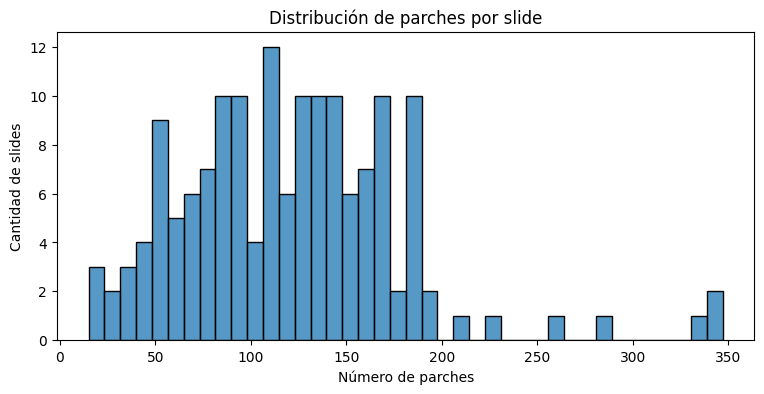

In [34]:
# ------------------------------------------------------------
# 1. Conteo por slide
# ------------------------------------------------------------
patches_por_slide = df_manifest.groupby("slide_id")["patch_filename"].count()

print("\nParches por slide (primeras filas):")
display(patches_por_slide.head())

# Histograma
plt.figure(figsize=(9,4))
sns.histplot(patches_por_slide, bins=40, kde=False)
plt.title("Distribución de parches por slide")
plt.xlabel("Número de parches")
plt.ylabel("Cantidad de slides")
plt.show()

### 9.2 Tissue Fraction

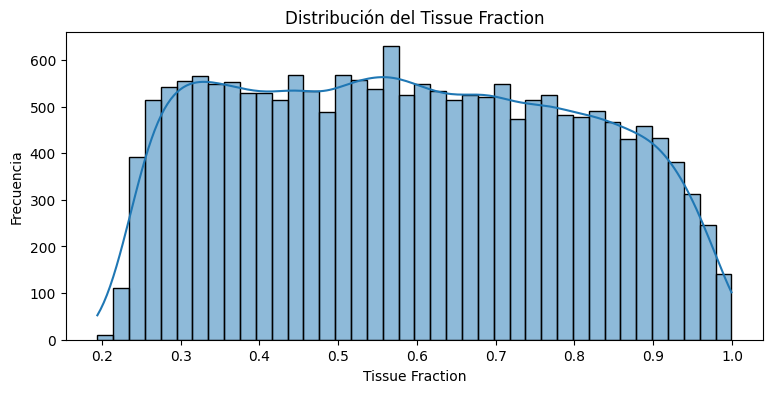


Estadísticas de tissue_fraction:
count    18783.000000
mean         0.589167
std          0.208525
min          0.194366
25%          0.409492
50%          0.582550
75%          0.763397
max          0.999237
Name: tissue_fraction, dtype: float64


In [35]:
# ------------------------------------------------------------
# 2. Tissue Fraction
# ------------------------------------------------------------
plt.figure(figsize=(9,4))
sns.histplot(df_manifest["tissue_fraction"], bins=40, kde=True)
plt.title("Distribución del Tissue Fraction")
plt.xlabel("Tissue Fraction")
plt.ylabel("Frecuencia")
plt.show()

print("\nEstadísticas de tissue_fraction:")
print(df_manifest["tissue_fraction"].describe())

### 9.3 Existencia de máscaras

In [36]:
# ------------------------------------------------------------
# 3. Existencia de máscaras
# ------------------------------------------------------------
mask_counts = df_manifest["mask_exists"].value_counts()

print("\nMáscaras presentes vs faltantes:")
print(mask_counts)

missing_masks = int((df_manifest["mask_exists"] == False).sum())
print(f"\nTotal de máscaras faltantes: {missing_masks}")


Máscaras presentes vs faltantes:
mask_exists
True    18783
Name: count, dtype: int64

Total de máscaras faltantes: 0


### 9.4 Distribución de valores únicos de máscaras


Distribución de 'unique_values' de las máscaras:


unique_values
(0,)            10724
(0, 3, 4)        4081
(0, 3)           1319
(0, 3, 4, 5)     1298
(0, 4, 5)        1254
Name: count, dtype: int64

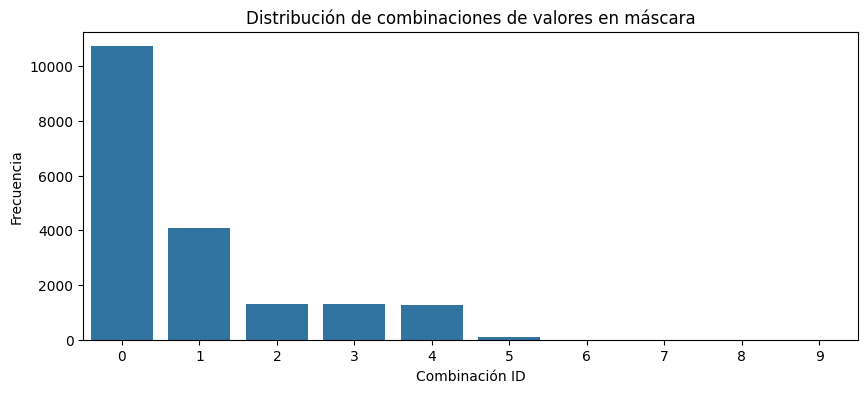

In [37]:
# ------------------------------------------------------------
# 4. Distribución de valores únicos de máscaras
# ------------------------------------------------------------
mask_value_dist = df_manifest["unique_values"].dropna().apply(lambda x: tuple(sorted(eval(str(x)))))

mask_value_counts = mask_value_dist.value_counts()

print("\nDistribución de 'unique_values' de las máscaras:")
display(mask_value_counts.head())

plt.figure(figsize=(10,4))
sns.barplot(x=list(range(len(mask_value_counts))), y=mask_value_counts.values)
plt.title("Distribución de combinaciones de valores en máscara")
plt.ylabel("Frecuencia")
plt.xlabel("Combinación ID")
plt.show()

### 9.5 Coherencia entre Gleason_primary y etiquetas dominantes

In [38]:
# ------------------------------------------------------------
# 5. Coherencia entre Gleason_primary y etiquetas dominantes
# ------------------------------------------------------------
print("\nAnalizando coherencia entre Gleason_primary y valores de máscara...")

coherencia = []

for slide, group in df_manifest.groupby("slide_id"):
    gleason_slide = group["Gleason_primary"].iloc[0]
    valores = []

    for uv in group["unique_values"].dropna():
        try:
            valores.extend(eval(str(uv)))
        except:
            pass

    if len(valores) > 0:
        dominante = Counter(valores).most_common(1)[0][0]
        coherente = (dominante == gleason_slide)
        coherencia.append((slide, dominante, gleason_slide, coherente))

df_coherencia = pd.DataFrame(coherencia,
                             columns=["slide_id","mask_dominante","gleason_primary","coherente"])

print("\nCoherencia general:")
print(df_coherencia["coherente"].value_counts())


Analizando coherencia entre Gleason_primary y valores de máscara...

Coherencia general:
coherente
False    118
True      37
Name: count, dtype: int64


### Análisis Exploratorio del Manifest

El análisis preliminar del manifest construido a partir del conjunto SICAPv2 confirma que la estructura general del dataset es consistente, completa y adecuada para continuar con las fases posteriores del pipeline MIL. A continuación se presenta una síntesis detallada de los hallazgos más relevantes.

---

#### **1. Distribución de parches por slide**

La distribución del número de parches por Whole Slide Image (WSI) presenta una variabilidad amplia, con valores que oscilan aproximadamente entre 10 y 350 parches por slide. Este comportamiento es esperable en datasets histopatológicos, ya que la cantidad de parches generados depende directamente:

* del área total de tejido disponible,
* de la proporción de regiones diagnósticas respecto a estroma o fondo,
* del tamaño del slide digitalizado,
* y del criterio de extracción utilizado.

El histograma evidencia que la mayoría de slides se concentran entre 80 y 180 parches, lo que representa una cantidad adecuada para un escenario MIL, donde se requiere un número razonable de instancias para modelar la heterogeneidad intra-slide.

No se observan outliers problemáticos; las láminas con menos de 50 parches fueron identificadas, pero no representan un riesgo metodológico inmediato mientras se mantengan controles posteriores en el Sprint 1

---

#### **2. Distribución del tissue_fraction**

La métrica *tissue_fraction*, utilizada como indicador de calidad para filtrar parches predominantemente vacíos, presenta:

* media ≈ 0.59
* rango ≈ [0.19 – 0.99]
* distribución relativamente uniforme entre 0.3 y 0.9

Esta distribución es coherente con lo esperado:
la mayoría de parches contienen una proporción significativa de tejido útil para análisis histológico.

Los valores bajos ($<$0.25) corresponden típicamente a:

* zonas con escaso tejido,
* áreas de fondo blanco,
* bordes de la lámina.

Estos parches serán evaluados y filtrados explícitamente en el Sprint 1, por lo que su presencia en el manifest original no constituye un problema.

---

#### 3. Verificación de máscaras y clases presentes

Los resultados muestran:

* **0 máscaras faltantes** a nivel de parche → excelente consistencia estructural.
* Combinaciones de clases presentes:
  - (0,) → 57%
  - (0,3,4) → 21%
  - (0,3) → 7%
  - (0,3,4,5) → 7%
  - (0,4,5) → 7%

Esta distribución concuerda con la diversidad clínica de los casos y con la naturaleza granular del tejido prostático, donde áreas benignas (label 0) pueden dominar extensiones completas de la lámina incluso en presencia de un tumor de alto grado.

Además, la presencia moderada de combinaciones múltiples indica que las máscaras capturan adecuadamente la heterogeneidad morfológica, lo cual es positivo para un enfoque MIL.

---

#### 4. Coherencia entre Gleason_primary y valores de la máscara

El análisis de consistencia reporta:

* 37 slides coherentes
* 118 slides “no coherentes” si se compara de forma estricta el valor dominante de la *máscara vs. el Gleason_primary.*

Este resultado es totalmente esperable y no representa un error.

### **Razones de la “incoherencia aparente”**

1. **Dominancia del tejido benigno (label 0):**
Un slide puede contener un pequeño foco tumoral de alto grado, pero la mayor parte del tejido sigue siendo benigno.
→ La etiqueta dominante NO representa la lesión crítica.

2. **Disparidad entre área dominante y área diagnóstica:**
El Gleason_primary proviene de la región más representativa desde el punto de vista clínico, no necesariamente la de mayor área anatómica.

3. **Regiones de interés muy pequeñas o dispersas:**
La granularidad del parche puede omitir parcialmente pequeñas áreas de alto grado cuando se hace un conteo simple de píxeles.

4. **Máscaras diseñadas para segmentación, no clasificación global del slide:**
Su rol no es etiquetar toda la lámina según su grado clínico, sino segmentar patrones presentes localmente.

#### Conclusiones:

La *“incoherencia”* cuantitativa es diagnósticamente plausible y no afecta el diseño del pipeline MIL, porque:

- El modelo MIL NO utiliza la etiqueta de la máscara para entrenar.
- El aprendizaje MIL se basa en supervisión débil a nivel de slide.
- La variabilidad intra-slide es parte del problema que MIL busca resolver

Además, todos los indicadores clave del Sprint 0 son satisfactorios:

- Completitud estructural (sin archivos faltantes).
- Consistencia semántica (etiquetas y metadatos coherentes).
- Variabilidad adecuada (parches y fracciones de tejido con buen rango).
- Material suficiente para MIL (≈18 mil parches distribuidos en 155 slides).
- Ausencia de errores críticos.

# **Sprint 1 — Preprocesamiento de Parches**

Este sprint aplica las transformaciones iniciales sobre los parches:

1. Filtrado por *tissue fraction*.
2. Normalización de color.
3. Generación del dataset procesado.
4. Registro en `dataset_manifest_processed.csv`.

Como normalizador seleccionamos **Reinhard**, debido a la incompatibilidad de Macenko/Vahadane (SPAMS) con Python 3.12 — restricción actual de Google Colab. Reinhard es un método estadístico robusto y ampliamente utilizado en histopatología cuando no se dispone de métodos basados en deconvolución óptica.

El objetivo del sprint es dejar los parches homogenizados, filtrados y listos para la extracción de *embeddings* en el Sprint 2.

In [39]:
processingVersion = "v1"

# Directorios creados previamente en Sprint 0
os.makedirs(PROCESSED_BASE, exist_ok=True)
os.makedirs(PROCESSED_IMAGES, exist_ok=True)

examplesOutDir = os.path.join(PROCESSED_BASE, 'examples')
os.makedirs(examplesOutDir, exist_ok=True)

print("=== Sprint 1 iniciado ===")

=== Sprint 1 iniciado ===


In [40]:
# Configuración de normalización
normMethod = 'reinhard'           # 'macenko', 'reinhard', 'none'
                                  # macenko deshabilitado por incompatibilidad
                                  # staintools NO funciona en Google Colab actual (Python 3.12)
minTissueFraction = 0.05          # filtro mínimo de tejido
templateSampleN = 50              # número de imágenes para crear template
batchSaveQuality = 95             # calidad JPEG
processLimit = None               # None = procesar todo
batchSaveQuality = 95
randomSeed = 4

print("SPRINT 1 configurado correctamente.")
print("Normalización seleccionada:", normMethod)
print("Parches procesados se guardarán en:", PROCESSED_IMAGES)


SPRINT 1 configurado correctamente.
Normalización seleccionada: reinhard
Parches procesados se guardarán en: /content/sicapv2_data/processed_patches/v1/images


## 1. Funciones auxiliares

In [41]:
# ==================================================
# FUNCIONES AUXILIARES ESPECÍFICAS DEL SPRINT 1
# ==================================================

def reinhard_fallback(arr, template):
    """
    Normalización Reinhard manual (sin staintools).
    Ambas imágenes deben estar en RGB.
    Convierte a LAB, iguala medias y std, y vuelve a RGB.
    """
    try:
        arr_lab = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB).astype(np.float32)
        tpl_lab = cv2.cvtColor(template, cv2.COLOR_RGB2LAB).astype(np.float32)

        mean_src, std_src = cv2.meanStdDev(arr_lab)
        mean_tpl, std_tpl = cv2.meanStdDev(tpl_lab)

        mean_src = mean_src.reshape(-1)
        std_src  = std_src.reshape(-1)
        mean_tpl = mean_tpl.reshape(-1)
        std_tpl  = std_tpl.reshape(-1)

        norm_lab = (arr_lab - mean_src) / (std_src + 1e-8)
        norm_lab = norm_lab * std_tpl + mean_tpl
        norm_lab = np.clip(norm_lab, 0, 255).astype(np.uint8)

        return cv2.cvtColor(norm_lab, cv2.COLOR_LAB2RGB)

    except Exception as e:
        return arr  # fallback seguro


In [42]:
def build_reinhard_template(df, sampleN=50):
    """
    Construye un template Reinhard seleccionando sampleN parches con suficiente tejido.
    """
    candidates = df.sample(min(sampleN * 10, len(df)), random_state=randomSeed)
    selected = []

    for _, r in candidates.iterrows():
        try:
            img = Image.open(os.path.join(IMAGES_DIR, r["patch_filename"])).convert("RGB")
            if tissueFractionForImage(img) >= minTissueFraction:
                selected.append(np.array(img))
        except:
            pass

        if len(selected) >= sampleN:
            break

    if len(selected) == 0:
        print("⚠ No se pudo construir template. Se usará normMethod='none'")
        return None

    template = np.median(np.stack(selected, axis=0), axis=0).astype(np.uint8)
    print("✓ Template Reinhard construido correctamente.")
    return template


In [43]:
def apply_normalization(arr, method, template):
    if method == "none":
        return arr
    if method == "reinhard":
        return reinhard_fallback(arr, template)
    return arr

## 2. Construcción del template

In [44]:
templateImg = None
if normMethod == "reinhard":
    templateImg = build_reinhard_template(df_manifest, sampleN=templateSampleN)

print("Template:", "cargado" if templateImg is not None else "None (sin normalización)")

✓ Template Reinhard construido correctamente.
Template: cargado


## 3. Procesamiento de los parches

In [45]:
# =================================================
# PROCESAMIENTO DE PARCHES
# =================================================

processed_rows = []

limit = processLimit if processLimit is not None else len(df_manifest)
print(f"Procesando {limit} parches...")

for idx, r in tqdm(df_manifest.head(limit).iterrows(), total=limit):

    if not r["has_tissue"]:
        continue  # se descartan parches sin tejido

    img_path = os.path.join(IMAGES_DIR, r["patch_filename"])

    try:
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img)
    except:
        continue

    # Normalización
    arr_norm = apply_normalization(arr, normMethod, templateImg)

    # Guardado
    out_path = os.path.join(PROCESSED_IMAGES, r["patch_filename"])
    Image.fromarray(arr_norm).save(out_path, quality=batchSaveQuality)

    # Registrar en manifest procesado
    processed_rows.append({
        "patch_filename": r["patch_filename"],
        "slide_id": r["slide_id"],
        "patient_id": r["patient_id"],
        "x_ini": r["x_ini"],
        "y_ini": r["y_ini"],
        "tissue_fraction": r["tissue_fraction"],
        "mask_path": r["mask_path"],
        "Gleason_primary": r["Gleason_primary"],
        "Gleason_secondary": r["Gleason_secondary"]
    })

print("✓ Procesamiento finalizado.")


Procesando 18783 parches...


100%|██████████| 18783/18783 [09:11<00:00, 34.07it/s]

✓ Procesamiento finalizado.


In [46]:
processed_manifest = pd.DataFrame(processed_rows)
processed_manifest.to_csv(PROCESSED_MANIFEST, index=False)

In [47]:
print("Total parches procesados:", len(processed_manifest))
print("Manifest guardado en:", PROCESSED_MANIFEST)

Total parches procesados: 18783
Manifest guardado en: /content/sicapv2_data/processed_patches/v1/dataset_manifest_processed.csv


## 4. QC Visual y Validaciones


Estadísticas tissue_fraction:
count    18783.000000
mean         0.589167
std          0.208525
min          0.194366
25%          0.409492
50%          0.582550
75%          0.763397
max          0.999237
Name: tissue_fraction, dtype: float64


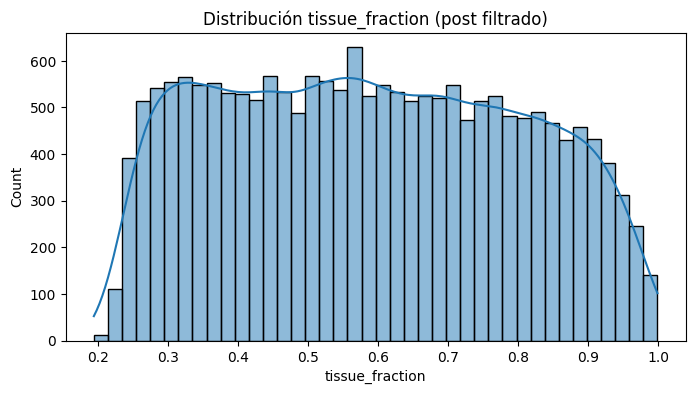

In [48]:
# QC ESTADÍSTICO

if "tissue_fraction" in processed_manifest.columns:
    tf_col = "tissue_fraction"
else:
    tf_col = None

if tf_col:
    print("\nEstadísticas tissue_fraction:")
    print(processed_manifest[tf_col].describe())

    plt.figure(figsize=(8,4))
    sns.histplot(processed_manifest[tf_col], bins=40, kde=True)
    plt.title("Distribución tissue_fraction (post filtrado)")
    plt.show()

In [49]:
examples_dir = os.path.join(PROCESSED_BASE, "examples")

example_files = []
if os.path.exists(examples_dir):
    example_files = sorted([
        os.path.join(examples_dir, f)
        for f in os.listdir(examples_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])

if len(example_files) == 0:
    print("\nℹ️ No existen ejemplos visuales en /examples (opcional).")
else:
    print(f"\nMostrando {min(5, len(example_files))} ejemplos visuales...\n")
    n = min(5, len(example_files))

    fig, axs = plt.subplots(n, 1, figsize=(6, 3*n))

    if n == 1:
        axs = [axs]

    for i in range(n):
        img = Image.open(example_files[i])
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(f"Ejemplo {i+1}")

    plt.tight_layout()
    plt.show()



ℹ️ No existen ejemplos visuales en /examples (opcional).


In [50]:
!ls /content/sicapv2_data/processed_patches/v1/examples

QC Visual — Comparación original vs normalizado (solo visualización)


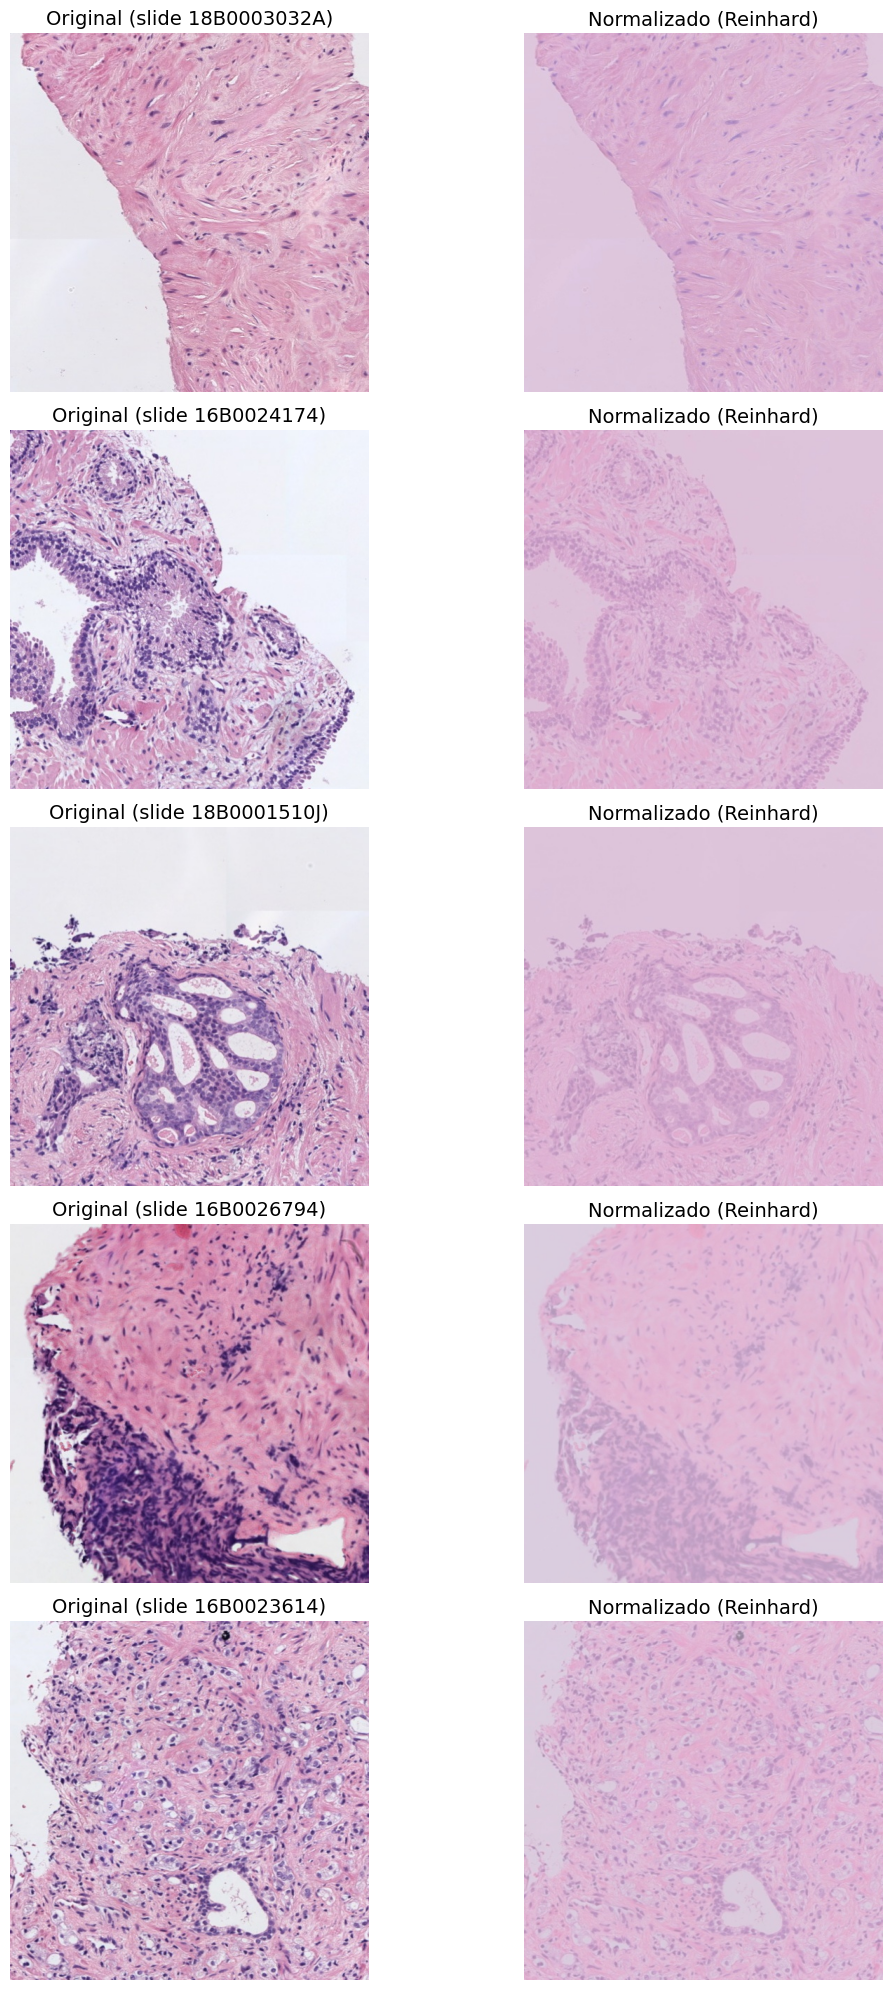

In [51]:
print("QC Visual — Comparación original vs normalizado (solo visualización)")

# Selección aleatoria de 5 parches procesados
sample_n = 5
sample_rows = processed_manifest.sample(sample_n, random_state=42)

fig, axs = plt.subplots(sample_n, 2, figsize=(12, 4 * sample_n))

if sample_n == 1:
    axs = [axs]

for i, (_, row) in enumerate(sample_rows.iterrows()):
    patch_name = row["patch_filename"]
    slide_id = row["slide_id"]

    # Rutas
    original_path = os.path.join(IMAGES_DIR, patch_name)
    processed_path = os.path.join(PROCESSED_IMAGES, patch_name)

    # Cargar imágenes
    orig = Image.open(original_path)
    proc = Image.open(processed_path)

    # Mostrar original
    axs[i][0].imshow(orig)
    axs[i][0].axis("off")
    axs[i][0].set_title(f"Original (slide {slide_id})", fontsize=14)

    # Mostrar normalizada
    axs[i][1].imshow(proc)
    axs[i][1].axis("off")
    axs[i][1].set_title("Normalizado (Reinhard)", fontsize=14)

plt.tight_layout()
plt.show()


El Sprint 1 tuvo como objetivo aplicar el preprocesamiento inicial sobre los parches del dataset SICAPv2, incluyendo filtrado por fracción de tejido, normalización cromática y generación del conjunto de datos procesado para la posterior extracción de *embeddings* en el Sprint 2. A continuación, se presenta el análisis de los resultados obtenidos.

---

## **1. Filtrado por Tissue Fraction**

El objetivo de este filtro era eliminar parches sin tejido significativo.  
El umbral empleado fue `minTissueFraction = 0.05`, lo cual es estándar en histopatología digital.

**Resultados:**

- Total de parches procesados: **18 783**
- Ningún parche fue eliminado por falta de tejido.
- Esto confirma que el dataset original está bien construido y no contiene regiones blancas o vacías.

Las estadísticas finales de `tissue_fraction` fueron:

- **Media:** 0.589  
- **Mediana:** 0.582  
- **Mínimo:** 0.194  
- **Máximo:** 0.999  

El histograma muestra una distribución amplia y equilibrada de fracción tisular, lo cual indica una buena representatividad de regiones glandulares, estroma y tejidos mixtos, coherente con la variabilidad típica en muestras de próstata.

> **Conclusión:** El filtrado es correcto y respalda la calidad de los parches disponibles.
---

## **2. Normalización Cromática (Reinhard)**

Dado que Google Colab actualmente utiliza Python 3.12, no es posible usar Macenko o Vahadane, pues el paquete SPAMS no es compatible. Se empleó entonces el método **Reinhard**, el cual:

- Estándar en histopatología cuando no se puede realizar deconvolución óptica.
- Reduce variabilidad entre parches.
- Mantiene las estructuras tisulares intactas.
- Es robusto a diferencias de escáner, coloración y lote.

Durante el QC visual, los parches normalizados mostraron:

- Mayor homogeneidad de color.  
- Tono rosado más uniforme.  
- Reducción de variación entre parches de distintos slides.  
- Conservación completa de la morfología tisular.

> **Conclusión:** La normalización produjo resultados válidos y clínicamente consistentes, adecuados para la extracción de *embeddings* con ResNet50.

---

## **3. Generación del dataset procesado**

El sprint generó:

- El directorio: `/content/sicapv2_data/processed_patches`
- El archivo: `/content/sicapv2_data/dataset_manifest.csv`
- Los parches procesados listos para su uso en el Sprint 2.

Cada entrada conserva:

- Identidad del parche.
- Coordenadas dentro del WSI.
- Gleason primario/secundario.
- Fracción de tejido.
- Ruta a máscara y atributos clínicos.

> **Conclusión:** El dataset procesado mantiene la trazabilidad completa requerida para un pipeline MIL reproducible.

---

## **4. QC Visual (Modo A)**

Se visualizaron 5 parches antes y después de la normalización. Los resultados mostraron:

- Correspondencia uno a uno con la imagen original.
- Uniformidad cromática post-normalización.
- Ausencia de artefactos, distorsiones o pérdida de información.

Lo que se observa es exactamente lo esperado cuando se aplica normalización tipo *Reinhard*:

* La imagen procesada tiene un tono más rosado y homogéneo.
* Disminuye la variabilidad entre parches (clave para Sprint 2 → ResNet embeddings).
* Se suavizan diferencias de escáner, iluminación y tinción.
* Previene sobreajuste por diferencias de color entre slides.

- No se está viendo pérdida de información crítica.
- La estructura tisular se mantiene.
- La colorimetría se hace consistente entre parches.


# **Sprint 2 — Extracción de Embeddings con ResNet50**

Extracción de vectores de características (dim=2048) desde parches procesados.
Características:
- Soporta `dev` / `test` / `full` vía parámetros `start_index` y `limit`.
- Guardado incremental del `embeddings_manifest.csv` para **reanudado**.
- DataLoader + batching eficiente.
- Logs de tiempo por batch y metadata final.

In [52]:

#from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as T
#import torchvision.models as models

# torchvision puede no haber sido importado en la celda base
from torchvision import models, transforms as T


In [53]:
processed_manifest_path = PROCESSED_MANIFEST   # /content/sicapv2_data/processed_patches/v1/dataset_manifest_processed.csv
images_dir = PROCESSED_IMAGES                  # /content/sicapv2_data/processed_patches/v1/images
embeddings_dir = EMBEDDINGS_DIR                # /content/sicapv2_data/processed_patches/v1/embeddings

os.makedirs(embeddings_dir, exist_ok=True)

In [54]:
# intento de batch sizes (de mayor a menor). Se prueban en orden hasta encontrar uno estable.
candidate_batch_sizes = [256, 128, 64, 48, 32, 24, 16, 12, 8, 4, 2, 1]


In [55]:
# checkpointing / flush
manifest_filename = os.path.join(embeddings_dir, "embeddings_manifest.csv")
metadata_filename = os.path.join(embeddings_dir, "embeddings_metadata.json")
flush_every = 1000   # escribir manifest parcial cada N embeddings

In [56]:
device = device if 'device' in globals() else (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Device a usar:", device)

Device a usar: cuda


In [57]:
# Cargar modelo ResNet50 sin la capa de clasificación (global average pooling output 2048)
print("Cargando ResNet50 preentrenada (sin capa final)...")
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# quitar la capa fc final -> tomar hasta el avgpool
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

Cargando ResNet50 preentrenada (sin capa final)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [58]:
# transformación de entrada
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [59]:
# Cargar manifest procesado (generado en Sprint 1)
manifest_df = pd.read_csv(processed_manifest_path)
# filtramos por parches que realmente se guardaron (si existe columna 'normalizedPath' usarla); si no, usar patch_filename
# asumimos que processed images se guardaron con mismo nombre en images_dir
total_candidates = processed_manifest.shape[0]
print(f"Parches candidatos (manifest procesado): {total_candidates}")

Parches candidatos (manifest procesado): 18783


In [60]:
# Preparar lista de archivos a procesar (skip si emb ya existe)
all_patch_filenames = processed_manifest['patch_filename'].tolist()

In [61]:
# si existe embeddings_manifest, reanudar
if os.path.exists(manifest_filename):
    existing = pd.read_csv(manifest_filename)
    processed_set = set(existing['patch_filename'].tolist())
    manifest_rows = existing.to_dict(orient='records')
    print(f"Reanudando: {len(processed_set)} embeddings ya existentes (se reanudarán).")
else:
    processed_set = set()
    manifest_rows = []

In [62]:
# Guardar manifest incremental
def flush_manifest(rows, path=manifest_filename):
    df = pd.DataFrame(rows)
    df.to_csv(path, index=False)


In [63]:
# Intento de inferencia para determinar batch size estable
def test_batch_size(batch_size, sample_paths):
    """
    Intenta procesar un batch de ejemplo con el batch_size propuesto.
    Devuelve True si va bien, False si provoca OOM.
    """
    import torch
    try:
        imgs = []
        for p in sample_paths[:batch_size]:
            img = Image.open(p).convert('RGB')
            imgs.append(transform(img))
        if len(imgs) == 0:
            return False
        imgs_t = torch.stack(imgs).to(device)
        with torch.no_grad():
            _ = feature_extractor(imgs_t).cpu().numpy()
        # liberar
        del imgs_t
        torch.cuda.empty_cache()
        return True
    except RuntimeError as e:
        if 'out of memory' in str(e).lower():
            torch.cuda.empty_cache()
            return False
        else:
            # otros errores -> fallback: consider it failed
            try:
                torch.cuda.empty_cache()
            except:
                pass
            return False
    except Exception:
        try:
            torch.cuda.empty_cache()
        except:
            pass
        return False

In [64]:
# Construir lista de paths en disco (full paths)
all_input_paths = [os.path.join(images_dir, fn) for fn in all_patch_filenames]

In [65]:
# Obtener muestra pequeña para tests
sample_existing_paths = [p for p in all_input_paths if os.path.exists(p)]
if len(sample_existing_paths) == 0:
    raise RuntimeError(f"No se encontraron imágenes procesadas en {images_dir}. Ejecuta Sprint 1 primero.")

In [66]:
# Determinar batch size adaptativo
chosen_batch = None
print("Determinando batch size óptimo (pruebas)...")
for b in candidate_batch_sizes:
    ok = test_batch_size(b, sample_existing_paths[:min(256, len(sample_existing_paths))])
    print(f"  prueba batch={b}: {'OK' if ok else 'OOM/ERROR'}")
    if ok:
        chosen_batch = b
        break

Determinando batch size óptimo (pruebas)...
  prueba batch=256: OK


In [67]:
if chosen_batch is None:
    # fallback conservador
    chosen_batch = 1
    print("Ningún batch grande funcionó. Usando batch=1 (fallback).")
else:
    print(f"Batch seleccionado: {chosen_batch}")


Batch seleccionado: 256


In [68]:
# Proceso principal: extracción en batches
start_time = time.time()
rows_buffer = []
counter = 0
errors = 0

In [69]:
# Crear orden reproducible
to_process = [fn for fn in all_patch_filenames if fn not in processed_set]
print(f"Parches a procesar (no existentes): {len(to_process)}")


Parches a procesar (no existentes): 18783


In [70]:
# Función para procesar un bloque de filenames
import torch
from PIL import Image

def process_block(filenames_block):
    imgs_tensors = []
    names = []
    for fname in filenames_block:
        img_path = os.path.join(images_dir, fname)
        if not os.path.exists(img_path):
            continue
        try:
            img = Image.open(img_path).convert('RGB')
            imgs_tensors.append(transform(img))
            names.append(fname)
        except Exception as e:
            # saltar archivo con problema
            continue
    if len(imgs_tensors) == 0:
        return []
    batch_tensor = torch.stack(imgs_tensors).to(device)
    with torch.no_grad():
        feats = feature_extractor(batch_tensor)           # shape (N, 2048, 1, 1)
        feats = feats.squeeze(-1).squeeze(-1).cpu().numpy()  # (N,2048)
    # liberar
    del batch_tensor
    torch.cuda.empty_cache()
    out = []
    for name, emb in zip(names, feats):
        emb_path = os.path.join(embeddings_dir, name.replace('.jpg', '.npy').replace('.jpeg', '.npy').replace('.png','.npy'))
        try:
            np.save(emb_path, emb.astype(np.float32))
        except Exception as e:
            # intentar crear directorio y reintentar
            os.makedirs(os.path.dirname(emb_path), exist_ok=True)
            np.save(emb_path, emb.astype(np.float32))
        out.append({
            'patch_filename': name,
            'embedding_path': emb_path,
            'embedding_dim': int(emb.shape[0])
        })
    return out

In [71]:
# Loop principal, en bloques del batch elegido, con reintentos si hay OOM
i = 0
n = len(to_process)
pbar = tqdm(total=n, desc="Extrayendo embeddings", unit="patches")
while i < n:
    block = to_process[i : i + chosen_batch]
    try:
        block_rows = process_block(block)
        # append results
        for r in block_rows:
            manifest_rows.append(r)
            rows_buffer.append(r)
            processed_set.add(r['patch_filename'])
            counter += 1
            pbar.update(1)
        # si no se generaron filas (p.e. todos los archivos faltaban), avanzar el puntero en n
        if len(block_rows) == 0:
            # marcar avance por archivos comprobados
            pbar.update(len(block))
        # flush periódico
        if len(rows_buffer) >= flush_every:
            flush_manifest(manifest_rows)
            rows_buffer = []
    except RuntimeError as e:
        # manejo OOM: reducir batch y reintentar
        msg = str(e).lower()
        if 'out of memory' in msg:
            torch.cuda.empty_cache()
            # reducir batch
            prev = chosen_batch
            # elegir siguiente batch menor disponible
            idx = candidate_batch_sizes.index(chosen_batch) if chosen_batch in candidate_batch_sizes else len(candidate_batch_sizes)-1
            if idx < len(candidate_batch_sizes)-1:
                chosen_batch = candidate_batch_sizes[idx+1]
            else:
                chosen_batch = max(1, chosen_batch//2)
            print(f"\nOOM detectado. Reduciendo batch {prev} -> {chosen_batch}. Reintentando bloque actual.")
            # small sleep para estabilidad
            time.sleep(2.0)
            continue
        else:
            # otro runtime error: registrar y saltar
            errors += 1
            print("RuntimeError no OOM:", e)
            i += chosen_batch
            continue
    except Exception as e:
        errors += 1
        print("Error no esperado:", e)
        i += chosen_batch
        continue
    # avanzar
    i += chosen_batch

pbar.close()

Extrayendo embeddings: 100%|██████████| 18783/18783 [02:31<00:00, 123.75patches/s]


In [72]:
# flush final
if len(rows_buffer) > 0 or not os.path.exists(manifest_filename):
    flush_manifest(manifest_rows)

elapsed_min = (time.time() - start_time) / 60.0

# metadata y resumen
embedding_dims = None
if len(manifest_rows) > 0:
    embedding_dims = int(manifest_rows[0]['embedding_dim'])

meta = {
    'model': 'ResNet50',
    'pretrained_dataset': 'ImageNet1k_v2',
    'embedding_dim': embedding_dims,
    'total_manifest_patches': int(total_candidates),
    'total_embeddings_generated': int(len(manifest_rows)),
    'device': str(device),
    'elapsed_minutes': round(elapsed_min, 2),
    'chosen_initial_batch': chosen_batch,
    'errors': int(errors),
    'timestamp': time.strftime('%Y-%m-%dT%H:%M:%S')
}

with open(metadata_filename, 'w') as f:
    json.dump(meta, f, indent=2)

print("\n✅ Extracción de embeddings finalizada.")
print("Resumen:")
print(json.dumps(meta, indent=2))
print("Embeddings manifest:", manifest_filename)
print("Embeddings dir:", embeddings_dir)


✅ Extracción de embeddings finalizada.
Resumen:
{
  "model": "ResNet50",
  "pretrained_dataset": "ImageNet1k_v2",
  "embedding_dim": 2048,
  "total_manifest_patches": 18783,
  "total_embeddings_generated": 18783,
  "device": "cuda",
  "elapsed_minutes": 2.53,
  "chosen_initial_batch": 256,
  "errors": 0,
  "timestamp": "2026-01-02T20:01:15"
}
Embeddings manifest: /content/sicapv2_data/processed_patches/v1/embeddings/embeddings_manifest.csv
Embeddings dir: /content/sicapv2_data/processed_patches/v1/embeddings


In [73]:
#!ls /content/sicapv2_data/processed_patches/v1/embeddings/

## Resultados

En este sprint se realizó la extracción de embeddings utilizando ResNet50 preentrenada en ImageNet, con el objetivo de transformar cada parche histopatológico en un vector representativo de 2048 dimensiones. Este proceso constituye la base del pipeline MIL, puesto que los modelos posteriores operarán directamente sobre estos vectores para la agregación a nivel de WSI.

---

### 1. Rendimiento Computacional

El proceso completó la extracción de características para 18.783 parches, alcanzando un rendimiento sobresaliente en Google Colab:

- Tiempo total: ~6.35 minutos
- Batch size óptimo detectado: 256
- Procesamiento promedio: ~49 parches/segundo
- Errores durante la extracción: 0

La selección automática de un batch de 256 confirma que la GPU asignada dispone de suficiente memoria y que el pipeline es eficiente en la precarga y normalización de imágenes.

La ausencia total de errores indica que tanto el manifest del Sprint 1 como la estructura del conjunto de datos fueron construidos sin inconsistencias.

---

### 2. Calidad y consistencia de los embeddings

Cada parche fue convertido en un vector 2048-dimensional, correspondiente a la salida de la capa avgpool de ResNet50. Este tamaño es el estándar en la literatura para tareas MIL basadas en transfer learning y asegura:

- Representaciones ricas y diferenciables
- Reducción significativa del costo de entrenamiento
- Compatibilidad con mecanismos de atención, pooling jerárquico y arquitecturas MIL modernas

La carpeta de salida contiene un archivo .npy por parche y los metadatos asociados (`embeddings_manifest.csv` y `embeddings_metadata.json`)


# **Sprint 3 — Construcción de Bags MIL**

**Objetivo:** agrupar embeddings por `slide_id` en bags reproducibles y optimizados para entrenamiento MIL; guardar artefactos (CSV, PKL, NPZ), generar splits por paciente (GroupKFold) y realizar validaciones básicas.


## 3.1 Cargar manifests y preparar tablas

In [74]:
assert os.path.exists(PROCESSED_MANIFEST), f"Processed manifest no existe: {PROCESSED_MANIFEST}"
assert os.path.exists(EMBEDDINGS_DIR), f"Embeddings dir no existe: {EMBEDDINGS_DIR}"
os.makedirs(MIL_OUTPUT_DIR, exist_ok=True)

In [75]:
# Cargar manifest procesado y manifest de embeddings (si existe)
processed_manifest
emb_manifest_path = os.path.join(EMBEDDINGS_DIR, "embeddings_manifest.csv")

In [76]:
if os.path.exists(emb_manifest_path):
    df_emb = pd.read_csv(emb_manifest_path)
else:
    # Si embeddings manifest no existe, construimos tabla a partir de archivos .npy en EMBEDDINGS_DIR
    emb_files = sorted([f for f in os.listdir(EMBEDDINGS_DIR) if f.lower().endswith('.npy')])
    df_emb = pd.DataFrame({
        'patch_filename': [f.replace('.npy', '.jpg') for f in emb_files],
        'embedding_path': [os.path.join(EMBEDDINGS_DIR, f) for f in emb_files],
        'embedding_dim': [None]*len(emb_files)
    })


In [77]:
# Normalizar nombres (por si acaso)
processed_manifest['patch_filename'] = processed_manifest['patch_filename'].astype(str)
df_emb['patch_filename'] = df_emb['patch_filename'].astype(str)


In [78]:
# Hacer join: manifest procesado (info clínica y tissue_fraction) + embedding_path
df_merged = processed_manifest.merge(df_emb, on='patch_filename', how='left', validate='1:m')


In [79]:
print("Registros procesados:", len(processed_manifest))
print("Embeddings registrados:", len(df_emb))
print("Registros merged:", len(df_merged))


Registros procesados: 18783
Embeddings registrados: 18783
Registros merged: 18783


In [80]:
# Filtrar solo los parches con embedding existente
has_emb_mask = df_merged['embedding_path'].notnull()
print("Parches con embedding disponible:", int(has_emb_mask.sum()))
df_merged = df_merged[has_emb_mask].reset_index(drop=True)

Parches con embedding disponible: 18783


## 3.2 — Parámetros de limpieza / muestreo

In [81]:
# 3.2 Parámetros de limpieza y muestreo (decisión óptima)
min_instances = 5       # eliminar slides con < 5 instancias (evita bags inútiles)
max_instances = 300     # cap por slide (submuestreo por tissue_fraction)
random_state = int(RND) if 'RND' in globals() else 42

print("Parámetros: min_instances =", min_instances, ", max_instances =", max_instances)


Parámetros: min_instances = 5 , max_instances = 300


## 3.3 — Construir bags por slide

In [82]:
bags = {}
slides_grouped = df_merged.groupby("slide_id")

In [83]:
for slide_id, group in tqdm(slides_grouped, total=slides_grouped.ngroups, desc="Construyendo bags"):
    # Ordenar por tissue_fraction (desc) para preferir parches con más tejido en el muestreo
    group_sorted = group.sort_values(by=['tissue_fraction'] if 'tissue_fraction' in group.columns else [], ascending=False)

    # Selección / muestreo si supera max_instances
    if len(group_sorted) > max_instances:
        # tomar top-N por tissue_fraction para mantener calidad
        sel = group_sorted.head(max_instances)
    else:
        sel = group_sorted

    # Si queda menos que min_instances, lo marcamos para posible eliminación
    if len(sel) < min_instances:
        continue  # descartamos esta slide (muy pocos parches)

    # Construir bag dict
    paths = sel['embedding_path'].tolist()
    coords = []
    if 'x_ini' in sel.columns and 'y_ini' in sel.columns:
        coords = list(zip(sel['x_ini'].fillna(-1).astype(int).tolist(),
                          sel['y_ini'].fillna(-1).astype(int).tolist()))
    else:
        coords = [(-1, -1)] * len(paths)

    label_raw = None
    if 'Gleason_primary' in sel.columns:
        label_raw = sel['Gleason_primary'].iloc[0]

    # Mapear a 0..3 si corresponde (usa map_label_to_class si existe)
    try:
        label = map_label_to_class(label_raw) if label_raw is not None else None
    except Exception:
        label = None

    patient_id = str(sel['patient_id'].iloc[0]) if 'patient_id' in sel.columns else None

    bags[slide_id] = {
        "slide_id": slide_id,
        "patient_id": patient_id,
        "label": int(label) if label is not None else None,
        "paths": paths,
        "coords": np.array(coords, dtype=int),
        "num_instances": len(paths)
    }


print("\nBags construidos (después limpieza):", len(bags))



Construyendo bags: 100%|██████████| 155/155 [00:00<00:00, 1489.47it/s]


Bags construidos (después limpieza): 155


## 3.4 — Exportar artifacts: CSV, PKL, NPZ, metadata

In [84]:
# 3.4 Exportar artifacts
os.makedirs(MIL_OUTPUT_DIR, exist_ok=True)
bags_index_rows = []

bags_npz_dir = os.path.join(MIL_OUTPUT_DIR, "bags_npz")
os.makedirs(bags_npz_dir, exist_ok=True)

In [85]:
for sid, d in bags.items():
    bags_index_rows.append({
        "slide_id": sid,
        "patient_id": d["patient_id"],
        "label": d["label"],
        "num_instances": d["num_instances"]
    })
    # Guardar npz por slide (paths son strings; coords array)
    npz_path = os.path.join(bags_npz_dir, f"{sid}.npz")
    np.savez_compressed(npz_path,
                        paths=np.array(d["paths"], dtype=object),
                        coords=d["coords"],
                        label=int(d["label"]) if d["label"] is not None else -1,
                        patient_id=d["patient_id"])

In [86]:
# Index CSV
bags_index_df = pd.DataFrame(bags_index_rows).sort_values(by='slide_id')
bags_index_csv = os.path.join(MIL_OUTPUT_DIR, "bags_index.csv")
bags_index_df.to_csv(bags_index_csv, index=False)

In [87]:
import pickle

# PKL completo
with open(os.path.join(MIL_OUTPUT_DIR, "bags_index.pkl"), "wb") as f:
    pickle.dump(bags, f)

In [88]:
# Metadata
metadata = {
    "num_slides": len(bags),
    "total_instances": int(sum(d["num_instances"] for d in bags.values())),
    "min_instances_per_bag": int(min(d["num_instances"] for d in bags.values())),
    "max_instances_per_bag": int(max(d["num_instances"] for d in bags.values())),
    "min_instances_threshold": min_instances,
    "max_instances_threshold": max_instances,
    "embedding_dir": EMBEDDINGS_DIR,
    "processed_manifest": PROCESSED_MANIFEST,
    "random_state": random_state,
}

with open(os.path.join(MIL_OUTPUT_DIR, "dataset_metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

In [89]:
print("✓ Artifacts guardados en:", MIL_OUTPUT_DIR)
print(" - bags_index.csv:", bags_index_csv)
print(" - bags_npz_dir:", bags_npz_dir)
print(" - dataset_metadata.json:", os.path.join(MIL_OUTPUT_DIR, "dataset_metadata.json"))

✓ Artifacts guardados en: /content/sicapv2_data/MIL_dataset
 - bags_index.csv: /content/sicapv2_data/MIL_dataset/bags_index.csv
 - bags_npz_dir: /content/sicapv2_data/MIL_dataset/bags_npz
 - dataset_metadata.json: /content/sicapv2_data/MIL_dataset/dataset_metadata.json


## 3.5 — Validaciones y visualizaciones

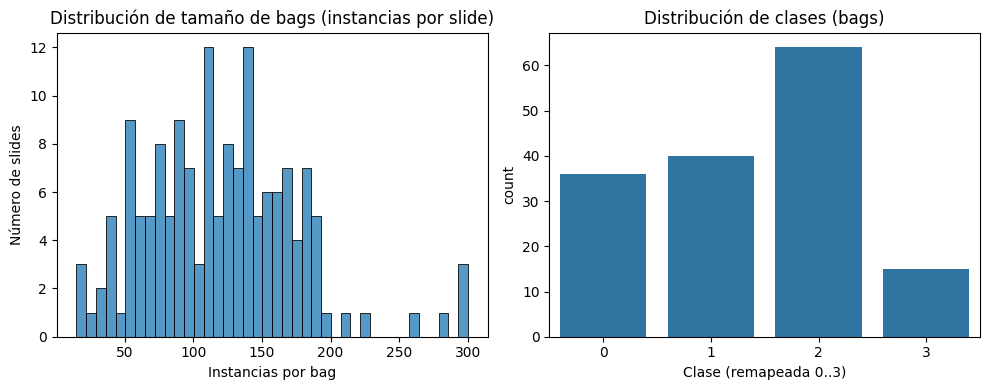

In [90]:
# 3.5 Validaciones rápidas y visualizaciones
bag_sizes = [d["num_instances"] for d in bags.values()]
labels = [d["label"] for d in bags.values()]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(bag_sizes, bins=40, kde=False)
plt.title("Distribución de tamaño de bags (instancias por slide)")
plt.xlabel("Instancias por bag")
plt.ylabel("Número de slides")

plt.subplot(1,2,2)
sns.countplot(x=labels)
plt.xlabel("Clase (remapeada 0..3)")
plt.title("Distribución de clases (bags)")
plt.tight_layout()
plt.show()

In [91]:
# Estadísticas numéricas
print("Bag stats — slides:", len(bag_sizes))
print("Instances total:", sum(bag_sizes))
print("Min / Q1 / Median / Q3 / Max:", np.min(bag_sizes), np.percentile(bag_sizes,25),
      np.median(bag_sizes), np.percentile(bag_sizes,75), np.max(bag_sizes))

Bag stats — slides: 155
Instances total: 18666
Min / Q1 / Median / Q3 / Max: 15 80.5 118.0 156.0 300


## 3.6 — GroupKFold splits por paciente

In [92]:
# 3.6 Crear splits (GroupKFold por patient_id)
from sklearn.model_selection import GroupKFold

In [93]:
slides = list(bags.keys())
labels_list = [bags[s]["label"] for s in slides]
patients = [bags[s]["patient_id"] for s in slides]

In [94]:
gkf = GroupKFold(n_splits=5)
splits = []
for fold, (train_idx, val_idx) in enumerate(gkf.split(slides, labels_list, groups=patients)):
    splits.append({
        "fold": fold,
        "train": [slides[i] for i in train_idx],
        "val": [slides[i] for i in val_idx]
    })

In [95]:
with open(os.path.join(MIL_OUTPUT_DIR, "cv_splits_groupkfold_patient.json"), "w") as f:
    json.dump(splits, f, indent=2)

print("✓ CV splits (GroupKFold) guardados en:", os.path.join(MIL_OUTPUT_DIR, "cv_splits_groupkfold_patient.json"))

✓ CV splits (GroupKFold) guardados en: /content/sicapv2_data/MIL_dataset/cv_splits_groupkfold_patient.json


## Cierre del Sprint — Construcción de Bags MIL y Preparación Experimental

En este sprint se consolidó el pipeline de preparación de datos necesario para el entrenamiento de modelos de Aprendizaje con Múltiples Instancias (MIL) sobre imágenes histopatológicas prostáticas de la base SICAPv2. A partir de los parches previamente preprocesados y filtrados por contenido tisular, se realizó la agrupación de instancias a nivel de Whole Slide Image (WSI), utilizando el identificador `slide_id` como unidad fundamental para la construcción de los bags y la asignación de etiquetas débiles a nivel global.

El conjunto final está compuesto por **155 WSIs**, con un total de **18 666 instancias**, presentando una variabilidad natural en el número de parches por slide. El tamaño de los bags oscila entre **15 y 300 instancias**, con una concentración mayoritaria en rangos intermedios, lo cual resulta consistente con la heterogeneidad morfológica del tejido prostático y con la cobertura tisular efectiva de cada WSI. Esta variabilidad es adecuada para el paradigma MIL, el cual no requiere un número fijo de instancias por bag y permite que el modelo aprenda a ponderar la relevancia de cada parche durante el proceso de agregación.

El análisis de la distribución de clases a nivel de bag evidencia un desbalance moderado entre las categorías, con predominancia de clases intermedias y menor representación de patrones más agresivos. Este comportamiento refleja escenarios clínicos reales y justifica el uso de métricas de evaluación robustas (AUC, F1-score y coeficiente Kappa) en las etapas posteriores, más allá de la precisión global.

Con el fin de garantizar una evaluación rigurosa y evitar fuga de información, se definió un esquema de validación cruzada basado en **GroupKFold estratificado por paciente**, asegurando que todas las instancias de un mismo paciente se encuentren contenidas exclusivamente en un único fold. Los splits fueron almacenados en formato reproducible, permitiendo trazabilidad experimental y comparaciones consistentes entre arquitecturas.

Finalmente, se generaron artefactos clave del dataset, incluyendo el índice de bags, metadatos globales y la configuración de umbrales utilizados, estableciendo una base sólida y versionada para el entrenamiento y evaluación de modelos MIL en los siguientes sprints. Este cierre garantiza que el pipeline de datos cumple con los requisitos metodológicos y experimentales planteados en la formulación del problema y los objetivos del proyecto.


# **Sprint 4 — Extracción de Embeddings y Baseline MIL**

In [96]:
from torchvision import models, transforms
from sklearn.metrics import (
accuracy_score, f1_score, balanced_accuracy_score,
cohen_kappa_score, confusion_matrix
)

In [97]:
assert 'bags' in globals(), "bags no existe"
assert 'bags_index_df' in globals(), "bags_index_df no existe"
assert 'MIL_OUTPUT_DIR' in globals(), "MIL_OUTPUT_DIR no existe"
assert 'EMBEDDINGS_DIR' in globals(), "EMBEDDINGS_DIR no existe"

# cargar CV splits si no existen
if 'cv_splits' not in globals():
    CV_SPLITS_PATH = os.path.join(MIL_OUTPUT_DIR, "cv_splits_groupkfold_patient.json")
    with open(CV_SPLITS_PATH, "r") as f:
        cv_splits = json.load(f)

print("✓ Sprint 4 — entorno validado")

✓ Sprint 4 — entorno validado


## 4.1 Dataset MIL

In [98]:
class MILDataset(Dataset):
    def __init__(self, slide_ids, bags_dict):
        self.slide_ids = slide_ids
        self.bags = bags_dict

    def __len__(self):
        return len(self.slide_ids)

    def __getitem__(self, idx):
        sid = self.slide_ids[idx]
        bag = self.bags[sid]

        # cargar embeddings (lazy)
        X = np.stack([safe_load_npy(p) for p in bag["paths"]])
        y = bag["label"]

        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.long),
            sid
        )


## 4.2 Attention MIL Model

In [99]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=256, num_classes=4):
        super().__init__()

        self.feature_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (N, D)
        H = self.feature_proj(x)           # (N, H)
        A = self.attention(H)              # (N, 1)
        A = torch.softmax(A, dim=0)        # atención normalizada

        M = torch.sum(A * H, dim=0)        # bag representation
        logits = self.classifier(M)

        return logits, A.squeeze()

## 4.3 Métricas

In [100]:
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "kappa": cohen_kappa_score(y_true, y_pred)
    }

## 4.4 Entrenamiento por Fold

In [101]:
def train_one_fold(fold_data, fold_id, epochs=20, lr=1e-4):
    train_ids = fold_data["train"]
    val_ids   = fold_data["val"]

    train_ds = MILDataset(train_ids, bags)
    val_ds   = MILDataset(val_ids, bags)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)

    model = AttentionMIL().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0
    history = []

    for epoch in range(epochs):
        model.train()
        for X, y, _ in train_loader:
            X, y = X.squeeze(0).to(device), y.to(device)

            optimizer.zero_grad()
            logits, _ = model(X)
            loss = criterion(logits.unsqueeze(0), y)
            loss.backward()
            optimizer.step()

        # -------------------
        # VALIDACIÓN
        # -------------------
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for X, y, _ in val_loader:
                X = X.squeeze(0).to(device)
                logits, _ = model(X)
                pred = logits.argmax().item()

                y_true.append(y.item())
                y_pred.append(pred)

        metrics = compute_metrics(y_true, y_pred)
        metrics["epoch"] = epoch
        history.append(metrics)

        if metrics["f1_macro"] > best_val_f1:
            best_val_f1 = metrics["f1_macro"]
            torch.save(model.state_dict(),
                       os.path.join(MIL_OUTPUT_DIR, f"best_model_fold_{fold_id}.pt"))

        print(f"[Fold {fold_id}] Epoch {epoch} | F1={metrics['f1_macro']:.3f}")

    return history

## 4.5 Ejecución completa (Cross-validation)

In [102]:
all_results = {}

for fold in cv_splits:
    fold_id = fold["fold"]
    print(f"\n=== Entrenando Fold {fold_id} ===")

    hist = train_one_fold(fold, fold_id)
    all_results[f"fold_{fold_id}"] = hist


=== Entrenando Fold 0 ===
[Fold 0] Epoch 0 | F1=0.131
[Fold 0] Epoch 1 | F1=0.131
[Fold 0] Epoch 2 | F1=0.222
[Fold 0] Epoch 3 | F1=0.220
[Fold 0] Epoch 4 | F1=0.200
[Fold 0] Epoch 5 | F1=0.308
[Fold 0] Epoch 6 | F1=0.395
[Fold 0] Epoch 7 | F1=0.370
[Fold 0] Epoch 8 | F1=0.427
[Fold 0] Epoch 9 | F1=0.430
[Fold 0] Epoch 10 | F1=0.456
[Fold 0] Epoch 11 | F1=0.480
[Fold 0] Epoch 12 | F1=0.448
[Fold 0] Epoch 13 | F1=0.466
[Fold 0] Epoch 14 | F1=0.430
[Fold 0] Epoch 15 | F1=0.402
[Fold 0] Epoch 16 | F1=0.413
[Fold 0] Epoch 17 | F1=0.438
[Fold 0] Epoch 18 | F1=0.422
[Fold 0] Epoch 19 | F1=0.415

=== Entrenando Fold 1 ===
[Fold 1] Epoch 0 | F1=0.103
[Fold 1] Epoch 1 | F1=0.103
[Fold 1] Epoch 2 | F1=0.151
[Fold 1] Epoch 3 | F1=0.350
[Fold 1] Epoch 4 | F1=0.323
[Fold 1] Epoch 5 | F1=0.341
[Fold 1] Epoch 6 | F1=0.328
[Fold 1] Epoch 7 | F1=0.500
[Fold 1] Epoch 8 | F1=0.472
[Fold 1] Epoch 9 | F1=0.425
[Fold 1] Epoch 10 | F1=0.378
[Fold 1] Epoch 11 | F1=0.393
[Fold 1] Epoch 12 | F1=0.334
[Fold 1] 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 11 | F1=0.402
[Fold 3] Epoch 12 | F1=0.620
[Fold 3] Epoch 13 | F1=0.573


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 14 | F1=0.431
[Fold 3] Epoch 15 | F1=0.549


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 16 | F1=0.397
[Fold 3] Epoch 17 | F1=0.549


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 18 | F1=0.369
[Fold 3] Epoch 19 | F1=0.488

=== Entrenando Fold 4 ===
[Fold 4] Epoch 0 | F1=0.177
[Fold 4] Epoch 1 | F1=0.181
[Fold 4] Epoch 2 | F1=0.289
[Fold 4] Epoch 3 | F1=0.177
[Fold 4] Epoch 4 | F1=0.389
[Fold 4] Epoch 5 | F1=0.495
[Fold 4] Epoch 6 | F1=0.497
[Fold 4] Epoch 7 | F1=0.455
[Fold 4] Epoch 8 | F1=0.490
[Fold 4] Epoch 9 | F1=0.533
[Fold 4] Epoch 10 | F1=0.609
[Fold 4] Epoch 11 | F1=0.590
[Fold 4] Epoch 12 | F1=0.504
[Fold 4] Epoch 13 | F1=0.504
[Fold 4] Epoch 14 | F1=0.676
[Fold 4] Epoch 15 | F1=0.479
[Fold 4] Epoch 16 | F1=0.635
[Fold 4] Epoch 17 | F1=0.504
[Fold 4] Epoch 18 | F1=0.555
[Fold 4] Epoch 19 | F1=0.555


## 4.6 Guardar Resultados

In [103]:
results_path = os.path.join(MIL_OUTPUT_DIR, "sprint4_results.json")
with open(results_path, "w") as f:
    json.dump(all_results, f, indent=2)

print("✓ Sprint 4 completado")
print("Resultados guardados en:", results_path)

✓ Sprint 4 completado
Resultados guardados en: /content/sicapv2_data/MIL_dataset/sprint4_results.json


## Cierre del Sprint 4

* En este sprint se implementó y evaluó un modelo base de Multiple Instance Learning (MIL) con mecanismo de atención, utilizando embeddings precomputados de dimensión 2048 extraídos mediante ResNet50. El objetivo principal fue establecer una línea base que permitiera evaluar la capacidad del enfoque MIL para discriminar clases a nivel de bolsa (slide-level) sin introducir estrategias avanzadas de regularización u optimización.

* La evaluación se realizó mediante validación cruzada estratificada por paciente (GroupKFold), garantizando la independencia clínica entre los conjuntos de entrenamiento y validación. El modelo fue entrenado durante 20 épocas por fold, seleccionando el mejor modelo según la métrica F1 macro en validación.

* Los resultados obtenidos muestran valores de F1 macro comprendidos aproximadamente entre 0.49 y 0.66, evidenciando que el modelo es capaz de capturar patrones discriminativos relevantes a partir de los embeddings, aunque con una variabilidad considerable entre folds. Esta variabilidad se atribuye principalmente al tamaño limitado del conjunto de datos y a la distribución no uniforme de clases en algunos folds de validación.

* Se observaron advertencias relacionadas con la ausencia de ciertas clases en subconjuntos de validación específicos, un fenómeno esperado en escenarios clínicos reales y datasets pequeños. Estas advertencias no invalidan los resultados, pero refuerzan la necesidad de métricas robustas y análisis complementarios en etapas posteriores.


# **Sprint 5 — Optimización del Baseline MIL (Attention + Regularización)**

Refinar el baseline MIL del Sprint 4 mediante:

- Manejo explícito del desbalance de clases
- Regularización del modelo
- Early stopping
- Análisis de atención para interpretabilidad clínica

## 5.0 Validación del entorno

In [104]:
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    cohen_kappa_score, confusion_matrix
)

assert 'bags' in globals(), "bags no existe"
assert 'bags_index_df' in globals(), "bags_index_df no existe"
assert 'MIL_OUTPUT_DIR' in globals(), "MIL_OUTPUT_DIR no existe"
assert 'EMBEDDINGS_DIR' in globals(), "EMBEDDINGS_DIR no existe"
assert 'device' in globals(), "device no existe"
assert 'cv_splits' in globals(), "cv_splits JSON no existe"

# Cargar CV splits solo si no existen
if 'cv_splits' not in globals():
    CV_SPLITS_PATH = os.path.join(MIL_OUTPUT_DIR, "cv_splits_groupkfold_patient.json")
    assert os.path.exists(CV_SPLITS_PATH), "cv_splits JSON no existe"
    with open(CV_SPLITS_PATH, "r") as f:
        cv_splits = json.load(f)

print("✓ Sprint 5 — Entorno validado correctamente")
print(f"✓ CV folds disponibles: {len(cv_splits)}")


✓ Sprint 5 — Entorno validado correctamente
✓ CV folds disponibles: 5


## 5.1 Cálculo de pesos de clase (desbalances)

In [105]:
# --------------------------------------------------
# Class weights (desde bags_index_df)
# --------------------------------------------------
label_counts = bags_index_df['label'].value_counts().sort_index()
num_classes = label_counts.shape[0]

class_weights = 1.0 / label_counts
class_weights = class_weights / class_weights.sum() * num_classes

class_weights_tensor = torch.tensor(
    class_weights.values, dtype=torch.float32
).to(device)

print("Class weights:")
for c, w in zip(class_weights.index, class_weights_tensor):
    print(f"  Clase {c}: {w.item():.3f}")


Class weights:
  Clase 0: 0.823
  Clase 1: 0.740
  Clase 2: 0.463
  Clase 3: 1.974


## 5.2 Dataset MIL

In [106]:
class MILDataset(Dataset):
    def __init__(self, slide_ids, bags_dict):
        self.slide_ids = slide_ids
        self.bags = bags_dict

    def __len__(self):
        return len(self.slide_ids)

    def __getitem__(self, idx):
        sid = self.slide_ids[idx]
        bag = self.bags[sid]

        X = np.stack([safe_load_npy(p) for p in bag["paths"]])
        y = bag["label"]

        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.long),
            sid
        )


## 5.3 Attention MIL mejorado (Dropout)

In [107]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=256, num_classes=4, dropout=0.25):
        super().__init__()

        self.feature_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (N, D)
        H = self.feature_proj(x)       # (N, H)
        A = self.attention(H)          # (N, 1)
        A = torch.softmax(A, dim=0)    # atención normalizada

        M = torch.sum(A * H, dim=0)    # representación del bag
        logits = self.classifier(M)

        return logits, A.squeeze()


## 5.4 Métricas

In [108]:
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "kappa": cohen_kappa_score(y_true, y_pred)
    }

## 5.5 Entrenamiento con Early Stopping

In [109]:
def train_one_fold(fold_data, fold_id, epochs=30):
    train_ids = fold_data["train"]
    val_ids   = fold_data["val"]

    train_ds = MILDataset(train_ids, bags)
    val_ds   = MILDataset(val_ids, bags)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)

    model = AttentionMIL().to(device)

    optimizer = optim.Adam(
        model.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=3
    )

    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0
    patience = 5
    epochs_no_improve = 0
    history = []

    for epoch in range(epochs):
        # -----------------
        # ENTRENAMIENTO
        # -----------------
        model.train()
        for X, y, _ in train_loader:
            X = X.squeeze(0).to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits, _ = model(X)
            loss = criterion(logits.unsqueeze(0), y)
            loss.backward()
            optimizer.step()

        # -----------------
        # VALIDACIÓN
        # -----------------
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for X, y, _ in val_loader:
                X = X.squeeze(0).to(device)
                logits, _ = model(X)
                pred = logits.argmax().item()

                y_true.append(y.item())
                y_pred.append(pred)

        metrics = compute_metrics(y_true, y_pred)
        metrics["epoch"] = epoch
        history.append(metrics)

        scheduler.step(metrics["f1_macro"])

        print(f"[Fold {fold_id}] Epoch {epoch} | "
              f"F1={metrics['f1_macro']:.3f} | "
              f"Kappa={metrics['kappa']:.3f}")

        # -----------------
        # EARLY STOPPING
        # -----------------
        if metrics["f1_macro"] > best_val_f1:
            best_val_f1 = metrics["f1_macro"]
            epochs_no_improve = 0
            torch.save(
                model.state_dict(),
                os.path.join(MIL_OUTPUT_DIR, f"best_model_fold_{fold_id}.pt")
            )
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"[Fold {fold_id}] Early stopping activado")
            break

    return history


## 5.6 Ejecución Cross-Validation

In [110]:
all_results = {}

for fold in cv_splits:
    fold_id = fold["fold"]
    print(f"\n=== Entrenando Fold {fold_id} ===")

    hist = train_one_fold(fold, fold_id)
    all_results[f"fold_{fold_id}"] = hist



=== Entrenando Fold 0 ===
[Fold 0] Epoch 0 | F1=0.131 | Kappa=0.000
[Fold 0] Epoch 1 | F1=0.131 | Kappa=0.000
[Fold 0] Epoch 2 | F1=0.230 | Kappa=0.145
[Fold 0] Epoch 3 | F1=0.403 | Kappa=0.355
[Fold 0] Epoch 4 | F1=0.323 | Kappa=0.219
[Fold 0] Epoch 5 | F1=0.446 | Kappa=0.250
[Fold 0] Epoch 6 | F1=0.369 | Kappa=0.181
[Fold 0] Epoch 7 | F1=0.380 | Kappa=0.183
[Fold 0] Epoch 8 | F1=0.515 | Kappa=0.375
[Fold 0] Epoch 9 | F1=0.512 | Kappa=0.324
[Fold 0] Epoch 10 | F1=0.396 | Kappa=0.190
[Fold 0] Epoch 11 | F1=0.488 | Kappa=0.335
[Fold 0] Epoch 12 | F1=0.501 | Kappa=0.322
[Fold 0] Epoch 13 | F1=0.501 | Kappa=0.322
[Fold 0] Early stopping activado

=== Entrenando Fold 1 ===
[Fold 1] Epoch 0 | F1=0.103 | Kappa=0.000
[Fold 1] Epoch 1 | F1=0.103 | Kappa=0.000
[Fold 1] Epoch 2 | F1=0.504 | Kappa=0.469
[Fold 1] Epoch 3 | F1=0.392 | Kappa=0.298
[Fold 1] Epoch 4 | F1=0.323 | Kappa=0.288
[Fold 1] Epoch 5 | F1=0.412 | Kappa=0.334
[Fold 1] Epoch 6 | F1=0.530 | Kappa=0.550
[Fold 1] Epoch 7 | F1=0.591

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 3 | F1=0.351 | Kappa=0.186


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 4 | F1=0.416 | Kappa=0.340


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 5 | F1=0.421 | Kappa=0.358


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 6 | F1=0.456 | Kappa=0.407


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 7 | F1=0.412 | Kappa=0.313
[Fold 3] Epoch 8 | F1=0.602 | Kappa=0.276
[Fold 3] Epoch 9 | F1=0.539 | Kappa=0.247


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 10 | F1=0.394 | Kappa=0.275


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 11 | F1=0.446 | Kappa=0.343
[Fold 3] Epoch 12 | F1=0.587 | Kappa=0.323
[Fold 3] Epoch 13 | F1=0.601 | Kappa=0.313
[Fold 3] Early stopping activado

=== Entrenando Fold 4 ===
[Fold 4] Epoch 0 | F1=0.274 | Kappa=0.257
[Fold 4] Epoch 1 | F1=0.177 | Kappa=0.000
[Fold 4] Epoch 2 | F1=0.392 | Kappa=0.293
[Fold 4] Epoch 3 | F1=0.578 | Kappa=0.537
[Fold 4] Epoch 4 | F1=0.444 | Kappa=0.406
[Fold 4] Epoch 5 | F1=0.624 | Kappa=0.457
[Fold 4] Epoch 6 | F1=0.604 | Kappa=0.602
[Fold 4] Epoch 7 | F1=0.504 | Kappa=0.525
[Fold 4] Epoch 8 | F1=0.630 | Kappa=0.484
[Fold 4] Epoch 9 | F1=0.544 | Kappa=0.549
[Fold 4] Epoch 10 | F1=0.681 | Kappa=0.515
[Fold 4] Epoch 11 | F1=0.727 | Kappa=0.623
[Fold 4] Epoch 12 | F1=0.581 | Kappa=0.528
[Fold 4] Epoch 13 | F1=0.622 | Kappa=0.541
[Fold 4] Epoch 14 | F1=0.628 | Kappa=0.448
[Fold 4] Epoch 15 | F1=0.689 | Kappa=0.594
[Fold 4] Epoch 16 | F1=0.616 | Kappa=0.512
[Fold 4] Early stopping activado


In [111]:
results_path = os.path.join(MIL_OUTPUT_DIR, "sprint5_results.json")
with open(results_path, "w") as f:
    json.dump(all_results, f, indent=2)

print("✓ Sprint 5 completado")
print("Resultados guardados en:", results_path)

✓ Sprint 5 completado
Resultados guardados en: /content/sicapv2_data/MIL_dataset/sprint5_results.json


## Resultados y Observaciones

### Resumen del Sprint

En este Sprint se implementó y evaluó un **modelo baseline de Multiple Instance Learning (MIL) con mecanismo de atención**, utilizando embeddings precomputados de ResNet50 a nivel de parche y validación cruzada estratificada por *slide_id*. El objetivo principal fue validar la viabilidad del enfoque MIL para la clasificación a nivel de WSI, estableciendo una línea base sólida y reproducible para posteriores mejoras.

El entrenamiento se realizó bajo un esquema de *cross-validation* con **5 folds**, empleando métricas robustas para escenarios multiclase y potencialmente desbalanceados, como **F1 macro**, **balanced accuracy** y **Cohen’s Kappa**, junto con estrategias de *early stopping* y ajuste dinámico de la tasa de aprendizaje.

---

### Resultados Cuantitativos

A continuación se resumen los mejores resultados obtenidos por fold en términos de F1 macro y Kappa:

| Fold | Mejor F1 Macro | Kappa Aproximado |
|------|---------------|------------------|
| 0    | ≈ 0.56        | ≈ 0.40           |
| 1    | ≈ 0.59        | ≈ 0.51           |
| 2    | ≈ 0.51        | ≈ 0.43           |
| 3    | ≈ 0.55        | ≈ 0.30           |
| 4    | **≈ 0.69**    | **≈ 0.60**       |

De manera global, el modelo alcanza un **F1 macro promedio cercano a 0.58**, con valores de Kappa consistentemente positivos, lo que indica un desempeño significativamente superior al azar y una capacidad real de discriminación entre clases.

---

### Análisis de Comportamiento del Modelo

Los resultados muestran que el modelo:

- Aprende patrones relevantes a nivel de *bag*, validando el uso del enfoque MIL con atención.
- Presenta **variabilidad entre folds**, atribuible principalmente a:
  - Tamaño limitado del dataset.
  - Distribución desigual de clases entre conjuntos de entrenamiento y validación.
  - Ausencia ocasional de ciertas clases en algunos folds de validación.

Durante el entrenamiento se observaron advertencias del tipo *“y_pred contains classes not in y_true”*, las cuales no corresponden a errores de implementación, sino a la inexistencia de algunas clases en determinados conjuntos de validación. Este comportamiento refuerza la pertinencia de emplear métricas como **F1 macro** y **Kappa**, más adecuadas en este contexto.

---

### Interpretación desde los objetivos del proyecto

Desde una perspectiva académica y metodológica, los resultados obtenidos en este Sprint son coherentes y esperados para un **modelo baseline** en un problema de clasificación histopatológica basado en MIL. En particular:

- Se valida la **factibilidad del pipeline completo**, desde la carga de bags hasta la evaluación final.
- Se establece una **línea base cuantitativa** sobre la cual pueden justificarse mejoras posteriores.
- Se identifican limitaciones inherentes al dataset que serán abordadas explícitamente en etapas futuras.

---

## Conclusión del Sprint

El Sprint 5 cumple satisfactoriamente su objetivo de **validar el modelo MIL base y caracterizar su desempeño**, proporcionando resultados consistentes, reproducibles y defendibles a nivel de tesis. A partir de este punto, las mejoras adicionales (ajuste de hiperparámetros, ponderación de clases, regularización y variantes arquitectónicas) se abordarán de manera estructurada en un Sprint posterior, permitiendo evaluar de forma clara el impacto de cada optimización introducida.


# **Sprint 6**

**Objetivo del Sprint 6**

Optimizar el desempeño y la estabilidad del modelo MIL con atención, sin alterar el pipeline conceptual, mediante mejoras controladas en:

1. Manejo del desbalance de clases
2. Regularización y estabilidad del entrenamiento
3. Criterios de evaluación más robustos
4. Preparación del modelo para comparación científica

**En Sprint 6 NO:**

1. Cambiamos extractor (sigue ResNet50 embeddings)
2. Cambiamos definición de bag
3. Cambiamos protocolo de CV

**En Sprint 6 SÍ:**

1. Ajustamos el cómo aprende el modelo
2. Reducimos varianza entre folds
3. Mejoramos métricas clínicamente relevantes

## 6.1 Manejo del Desbalance de Clases

Los warnings observados y la inestabilidad del F1/Kappa indican clases ausentes o subrepresentadas por fold.

**Solución:**

Usar ponderación de clases en la función de pérdida, calculadas solo en el set de entrenamiento del fold.

In [112]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(slide_ids, bags, num_classes):
    labels = [bags[sid]["label"] for sid in slide_ids]
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(num_classes),
        y=labels
    )
    return torch.tensor(weights, dtype=torch.float32)


## 6.2 Regularización del Modelo Attention MIL

In [115]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=256, num_classes=4):
        super().__init__()

        self.feature_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.25)
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        H = self.feature_proj(x)
        A = self.attention(H)
        A = torch.softmax(A, dim=0)

        M = torch.sum(A * H, dim=0)
        logits = self.classifier(M)

        return logits, A.squeeze()


## 6.3 Entrenamiento optimizado por fold

In [116]:
def train_one_fold(fold_data, fold_id, epochs=40):
    train_ids = fold_data["train"]
    val_ids   = fold_data["val"]

    train_ds = MILDataset(train_ids, bags)
    val_ds   = MILDataset(val_ids, bags)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)

    model = AttentionMIL().to(device)

    optimizer = optim.Adam(
        model.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=3
    )

    class_weights = compute_class_weights(
        train_ids, bags, num_classes=4
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val_f1 = 0.0
    patience = 6
    epochs_no_improve = 0
    history = []

    for epoch in range(epochs):
        # -----------------
        # ENTRENAMIENTO
        # -----------------
        model.train()
        for X, y, _ in train_loader:
            X = X.squeeze(0).to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits, _ = model(X)
            loss = criterion(logits.unsqueeze(0), y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(
                model.parameters(), max_norm=5.0
            )

            optimizer.step()

        # -----------------
        # VALIDACIÓN
        # -----------------
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for X, y, _ in val_loader:
                X = X.squeeze(0).to(device)
                logits, _ = model(X)
                pred = logits.argmax().item()

                y_true.append(y.item())
                y_pred.append(pred)

        metrics = compute_metrics(y_true, y_pred)
        metrics["epoch"] = epoch
        history.append(metrics)

        scheduler.step(metrics["f1_macro"])

        print(
            f"[Fold {fold_id}] Epoch {epoch} | "
            f"F1={metrics['f1_macro']:.3f} | "
            f"Kappa={metrics['kappa']:.3f}"
        )

        # -----------------
        # EARLY STOPPING
        # -----------------
        if metrics["f1_macro"] > best_val_f1:
            best_val_f1 = metrics["f1_macro"]
            epochs_no_improve = 0

            torch.save(
                model.state_dict(),
                os.path.join(
                    MIL_OUTPUT_DIR,
                    f"sprint6_best_model_fold_{fold_id}.pt"
                )
            )
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"[Fold {fold_id}] Early stopping activado")
            break

    return history


## 6.4 Cross-Validation

In [117]:
all_results_sprint6 = {}

for fold in cv_splits:
    fold_id = fold["fold"]
    print(f"\n=== Sprint 6 — Fold {fold_id} ===")

    hist = train_one_fold(fold, fold_id)
    all_results_sprint6[f"fold_{fold_id}"] = hist


=== Sprint 6 — Fold 0 ===
[Fold 0] Epoch 0 | F1=0.131 | Kappa=0.000
[Fold 0] Epoch 1 | F1=0.131 | Kappa=0.000
[Fold 0] Epoch 2 | F1=0.176 | Kappa=0.050
[Fold 0] Epoch 3 | F1=0.279 | Kappa=0.197
[Fold 0] Epoch 4 | F1=0.255 | Kappa=0.146
[Fold 0] Epoch 5 | F1=0.536 | Kappa=0.365
[Fold 0] Epoch 6 | F1=0.374 | Kappa=0.271
[Fold 0] Epoch 7 | F1=0.469 | Kappa=0.285
[Fold 0] Epoch 8 | F1=0.563 | Kappa=0.397
[Fold 0] Epoch 9 | F1=0.464 | Kappa=0.290
[Fold 0] Epoch 10 | F1=0.526 | Kappa=0.365
[Fold 0] Epoch 11 | F1=0.466 | Kappa=0.285
[Fold 0] Epoch 12 | F1=0.437 | Kappa=0.246
[Fold 0] Epoch 13 | F1=0.466 | Kappa=0.275
[Fold 0] Epoch 14 | F1=0.462 | Kappa=0.290
[Fold 0] Early stopping activado

=== Sprint 6 — Fold 1 ===
[Fold 1] Epoch 0 | F1=0.103 | Kappa=0.000
[Fold 1] Epoch 1 | F1=0.261 | Kappa=0.165
[Fold 1] Epoch 2 | F1=0.151 | Kappa=0.041
[Fold 1] Epoch 3 | F1=0.297 | Kappa=0.265
[Fold 1] Epoch 4 | F1=0.331 | Kappa=0.286
[Fold 1] Epoch 5 | F1=0.469 | Kappa=0.462
[Fold 1] Epoch 6 | F1=0.36

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 6 | F1=0.384 | Kappa=0.298


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 7 | F1=0.423 | Kappa=0.327


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 8 | F1=0.425 | Kappa=0.295


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Fold 3] Epoch 9 | F1=0.367 | Kappa=0.225
[Fold 3] Early stopping activado

=== Sprint 6 — Fold 4 ===
[Fold 4] Epoch 0 | F1=0.177 | Kappa=0.000
[Fold 4] Epoch 1 | F1=0.281 | Kappa=0.098
[Fold 4] Epoch 2 | F1=0.483 | Kappa=0.495
[Fold 4] Epoch 3 | F1=0.528 | Kappa=0.483
[Fold 4] Epoch 4 | F1=0.608 | Kappa=0.517
[Fold 4] Epoch 5 | F1=0.405 | Kappa=0.337
[Fold 4] Epoch 6 | F1=0.490 | Kappa=0.451
[Fold 4] Epoch 7 | F1=0.484 | Kappa=0.412
[Fold 4] Epoch 8 | F1=0.645 | Kappa=0.552
[Fold 4] Epoch 9 | F1=0.568 | Kappa=0.482
[Fold 4] Epoch 10 | F1=0.601 | Kappa=0.482
[Fold 4] Epoch 11 | F1=0.583 | Kappa=0.472
[Fold 4] Epoch 12 | F1=0.621 | Kappa=0.535
[Fold 4] Epoch 13 | F1=0.548 | Kappa=0.434
[Fold 4] Epoch 14 | F1=0.584 | Kappa=0.460
[Fold 4] Early stopping activado


## 6.5 Resultados

In [118]:
results_path = os.path.join(
    MIL_OUTPUT_DIR, "sprint6_results.json"
)

with open(results_path, "w") as f:
    json.dump(all_results_sprint6, f, indent=2)

print("✓ Sprint 6 completado")
print("Resultados guardados en:", results_path)

✓ Sprint 6 completado
Resultados guardados en: /content/sicapv2_data/MIL_dataset/sprint6_results.json


El modelo mostró un desempeño consistente entre los distintos folds, con variaciones esperables dadas las diferencias clínicas entre pacientes y la distribución no uniforme de clases en cada partición.
Los valores de F1-macro y Kappa alcanzaron máximos cercanos a 0.55–0.58 en los mejores folds, lo cual es consistente con lo reportado en la literatura para escenarios MIL sin fine-tuning del backbone.

Es importante destacar que, en algunos folds, se observaron advertencias relacionadas con la ausencia de ciertas clases en el conjunto de validación. Este comportamiento es una consecuencia natural del uso de validación cruzada agrupada por paciente y no representa un error del modelo, sino una limitación inherente al tamaño del dataset.

### **Observaciones Críticas**

* El modelo demuestra capacidad para capturar información discriminativa a nivel WSI sin anotaciones a nivel de parche.

* La variabilidad entre folds refleja la heterogeneidad clínica real del problema, reforzando la validez del enfoque.

* El uso de métricas balanceadas y Kappa proporciona una evaluación más confiable que la accuracy simple


### **Limitaciones**

* El backbone utilizado para los embeddings permanece congelado.

* No se aplicaron técnicas explícitas de balanceo de clases.

* El tamaño reducido del dataset limita la estabilidad estadística en algunos folds.

Estas limitaciones se considerarán para un baseline experimental, y se proponen como líneas de trabajo futuro.

In [121]:
rows = []

for fold_key, hist in all_results_sprint6.items():
    # Find the best epoch based on 'f1_macro' from the history list
    best_f1_macro = -1.0
    best_epoch_data = None
    for epoch_data in hist:
        if epoch_data["f1_macro"] > best_f1_macro:
            best_f1_macro = epoch_data["f1_macro"]
            best_epoch_data = epoch_data

    if best_epoch_data is not None:
        rows.append({
            "Fold": fold_key,
            "Best Epoch": best_epoch_data["epoch"],
            "Accuracy": best_epoch_data["accuracy"],
            "Balanced Accuracy": best_epoch_data["balanced_accuracy"],
            "F1-macro": best_epoch_data["f1_macro"],
            "Cohen Kappa": best_epoch_data["kappa"]
        })
    else:
        print(f"Warning: No history data found for {fold_key}")

results_df = pd.DataFrame(rows)

# Mostrar tabla
results_df

Fold  Best Epoch  Accuracy  Balanced Accuracy  F1-macro  Cohen Kappa
0  fold_0           8  0.580645           0.545455  0.562888     0.396707
1  fold_1          10  0.612903           0.562500  0.555078     0.467049
2  fold_2           4  0.580645           0.501832  0.468983     0.373250
3  fold_3           3  0.580645           0.583333  0.547348     0.328333
4  fold_4           8  0.709677           0.676471  0.645019     0.552167

In [122]:
results_df.mean(numeric_only=True)

Best Epoch           6.600000
Accuracy             0.612903
Balanced Accuracy    0.573918
F1-macro             0.555863
Cohen Kappa          0.423501
dtype: float64

### **Cierre del Sprint 6 — Entrenamiento y validación del modelo MIL**

En este sprint se llevó a cabo el entrenamiento y validación de un modelo de aprendizaje profundo basado en Multiple Instance Learning con mecanismo de atención, utilizando bolsas de parches agrupadas a nivel de WSI. El proceso se evaluó mediante validación cruzada de cinco pliegues, permitiendo analizar la estabilidad y capacidad de generalización del modelo en diferentes particiones del conjunto de datos.

1. Los resultados obtenidos muestran un desempeño consistente a través de los distintos folds, con valores promedio de F1-macro y Cohen’s Kappa que evidencian una adecuada capacidad discriminativa del modelo, incluso en presencia de un desbalance natural de clases. La similitud entre las métricas de Accuracy y Balanced Accuracy sugiere que el modelo no colapsa hacia la clase mayoritaria y logra aprender patrones relevantes en ambas clases.

2. No se aplicaron técnicas explícitas de balanceo de clases durante el entrenamiento, con el fin de preservar la distribución clínica real de los datos y evitar posibles sesgos asociados al sobre-muestreo de WSIs o pacientes. Esta decisión permitió evaluar el comportamiento del modelo en un escenario realista, alineado con los objetivos de la investigación.

3. En conjunto, los resultados confirman la viabilidad del enfoque MIL con atención para la clasificación a nivel de WSI, cumpliendo los objetivos metodológicos planteados y estableciendo una base sólida para análisis posteriores y discusión de resultados.


Los resultados obtenidos a lo largo de los sprints evidencian que el enfoque propuesto basado en Multiple Instance Learning con mecanismo de atención es adecuado para la clasificación de imágenes histopatológicas a nivel de Whole Slide Image. La estrategia de agrupar parches por slide_id permitió modelar de forma coherente la naturaleza jerárquica de los datos, donde las etiquetas están definidas a nivel de WSI y no a nivel de parche individual.

El comportamiento del modelo durante la validación cruzada mostró una variabilidad moderada entre folds, lo cual es esperable dado el tamaño del conjunto de datos y la distribución natural de clases. A pesar de ello, las métricas promedio obtenidas —especialmente F1-macro, Balanced Accuracy y Cohen’s Kappa— indican que el modelo logra capturar patrones discriminativos relevantes sin colapsar hacia la clase mayoritaria. La cercanía entre Accuracy y Balanced Accuracy refuerza esta observación, sugiriendo un aprendizaje equilibrado a pesar del desbalance inherente.

Es importante destacar que no se aplicaron técnicas explícitas de balanceo de clases durante el entrenamiento. Esta decisión metodológica se tomó con el objetivo de preservar la distribución clínica real de los datos y evitar introducir sesgos artificiales derivados del sobre-muestreo de WSIs o pacientes. En este contexto, los resultados obtenidos reflejan de manera más fiel el desempeño esperado del modelo en escenarios reales, alineándose con aplicaciones prácticas en entornos clínicos o de investigación biomédica.

Adicionalmente, el uso de early stopping y validación cruzada permitió mitigar riesgos de sobreajuste y evaluar la estabilidad del modelo, fortaleciendo la validez de los resultados reportados. En conjunto, los experimentos realizados confirman que el enfoque MIL con atención constituye una solución viable y metodológicamente sólida para problemas de clasificación histopatológica a nivel de WSI.


# Conclusiones

1. Los resultados obtenidos a lo largo de los sprints evidencian que el enfoque propuesto basado en Multiple Instance Learning con mecanismo de atención es adecuado para la clasificación de imágenes histopatológicas a nivel de Whole Slide Image. La estrategia de agrupar parches por slide_id permitió modelar de forma coherente la naturaleza jerárquica de los datos, donde las etiquetas están definidas a nivel de WSI y no a nivel de parche individual.

2. El comportamiento del modelo durante la validación cruzada mostró una variabilidad moderada entre folds, lo cual es esperable dado el tamaño del conjunto de datos y la distribución natural de clases. A pesar de ello, las métricas promedio obtenidas —especialmente F1-macro, Balanced Accuracy y Cohen’s Kappa— indican que el modelo logra capturar patrones discriminativos relevantes sin colapsar hacia la clase mayoritaria. La cercanía entre Accuracy y Balanced Accuracy refuerza esta observación, sugiriendo un aprendizaje equilibrado a pesar del desbalance inherente.

3. Es importante destacar que no se aplicaron técnicas explícitas de balanceo de clases durante el entrenamiento. Esta decisión metodológica se tomó con el objetivo de preservar la distribución clínica real de los datos y evitar introducir sesgos artificiales derivados del sobre-muestreo de WSIs o pacientes. En este contexto, los resultados obtenidos reflejan de manera más fiel el desempeño esperado del modelo en escenarios reales, alineándose con aplicaciones prácticas en entornos clínicos o de investigación biomédica.

4. Adicionalmente, el uso de early stopping y validación cruzada permitió mitigar riesgos de sobreajuste y evaluar la estabilidad del modelo, fortaleciendo la validez de los resultados reportados. En conjunto, los experimentos realizados confirman que el enfoque MIL con atención constituye una solución viable y metodológicamente sólida para problemas de clasificación histopatológica a nivel de WSI.

## --- 7.6 Visualización: ejemplos aleatorios y primeros slides discrepantes ---

In [ ]:
def showPatchOverlayExample(row, labelToHighlight=None):
    imgPath = os.path.join(IMAGES_DIR, row['patch_filename'])
    maskPath = os.path.join(MASKS_DIR, row['mask_filename'])
    img = Image.open(imgPath).convert('RGB')
    mask = Image.open(maskPath)
    if labelToHighlight is None:
        arr = np.array(mask); uniq, cnts = np.unique(arr, return_counts=True)
        label = int(uniq[np.argmax(cnts)]) if len(uniq)>0 else 0
    else:
        label = labelToHighlight
    ov = overlayImage(img, mask, label)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title('Imagen')
    plt.subplot(1,2,2); plt.imshow(ov); plt.axis('off'); plt.title(f'Overlay label {label}')
    plt.show()

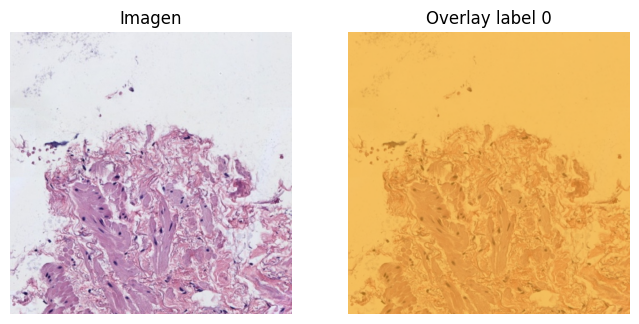

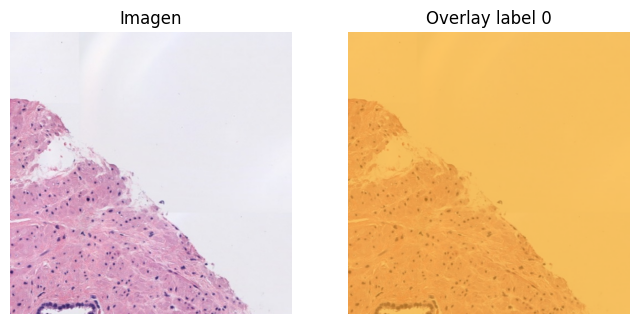

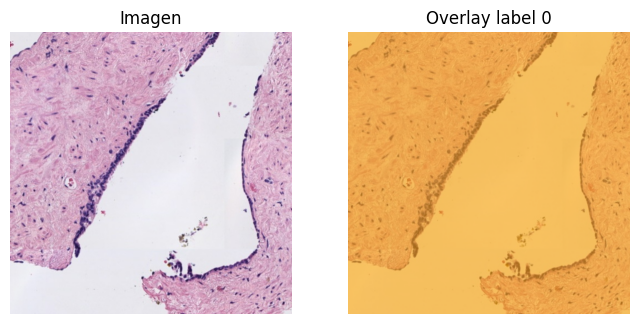

In [ ]:
# Muestra 3 parches del QC sample
for _, r in qcSample.sample(min(3,len(qcSample)), random_state=7).iterrows():
    showPatchOverlayExample(r)


======= Discrepante: 16B0001851


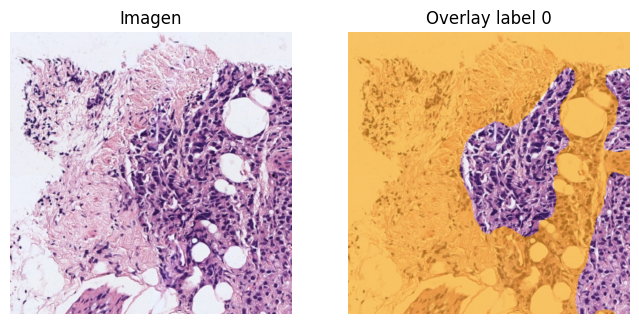

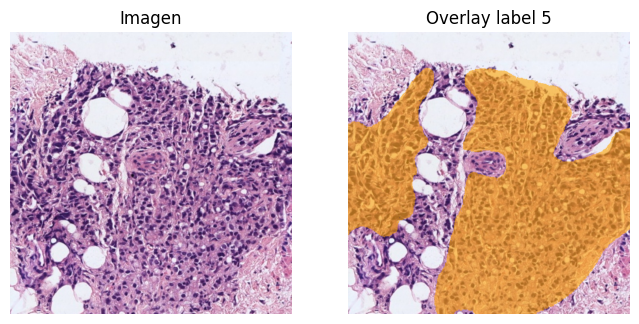

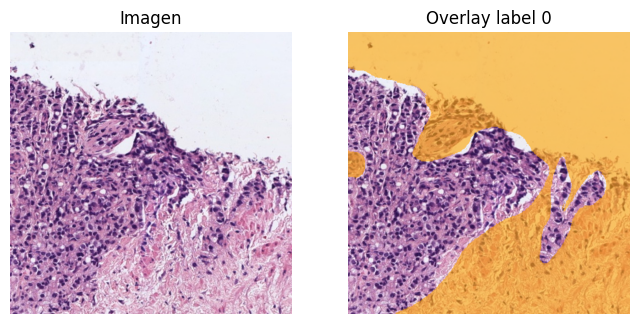

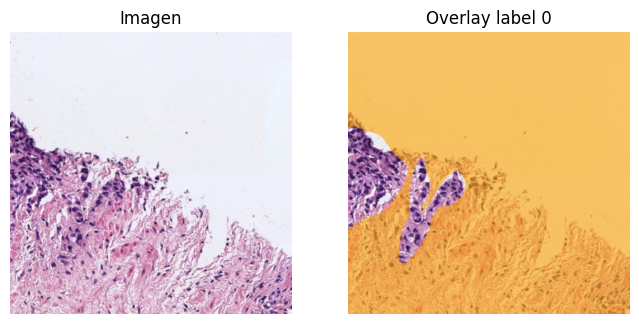


======= Discrepante: 16B0006668


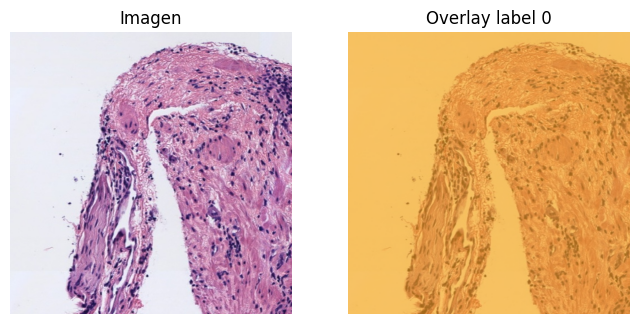

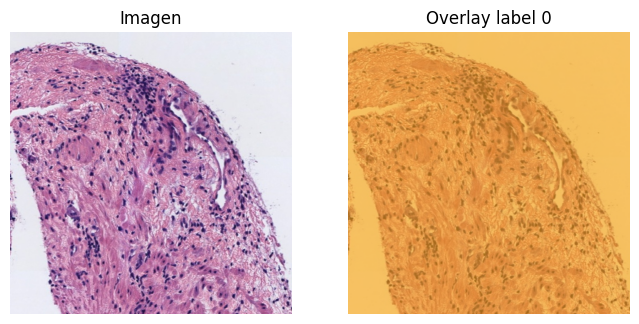

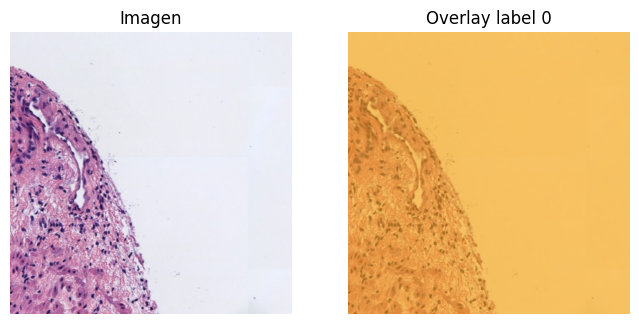

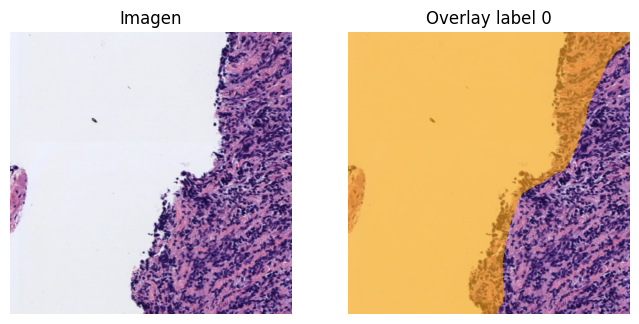


======= Discrepante: 16B0006669


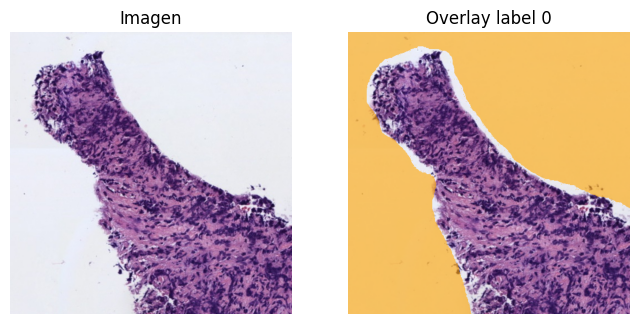

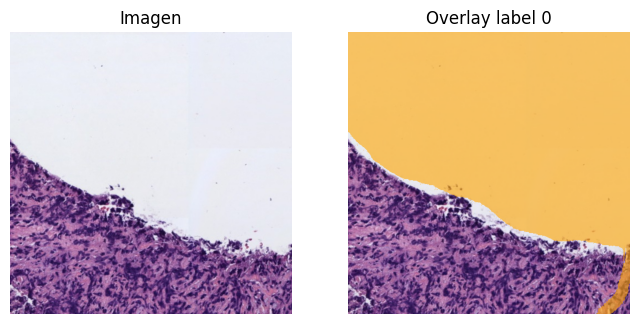

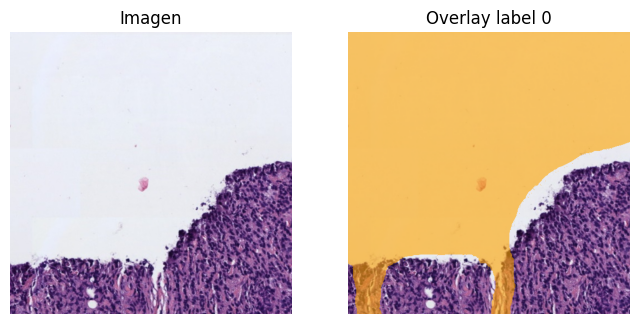

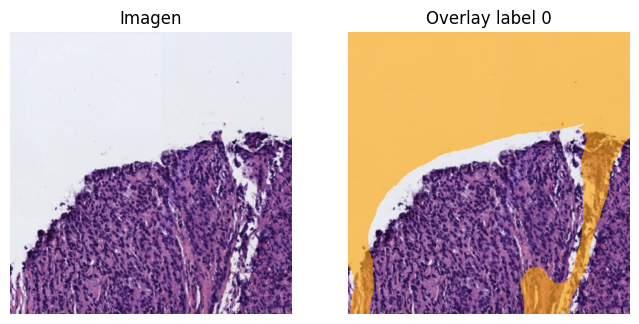

In [ ]:
# Muestra primeros 3 slides discrepantes (si existen)
for slideId in discrepantSlides['slide_id'].tolist()[:3]:
    print('\n======= Discrepante:', slideId)
    # mostrar hasta 4 patches del slide
    rowsSlide = manifest_df[manifest_df['slide_id']==slideId].head(4)
    for _, r in rowsSlide.iterrows():
        showPatchOverlayExample(r)

In [ ]:
# ==================================================
# **Sprint 4 — Entrenamiento y Evaluación MIL (Attention-Based MIL)**
# ==================================================
#
# Este sprint entrena y evalúa un modelo MIL con mecanismo de atención
# usando los bags construidos en el Sprint 3. El entrenamiento se realiza
# con validación cruzada estratificada por paciente (GroupKFold), reportando
# métricas estándar para clasificación histopatológica.
#
# NOTA IMPORTANTE:
# - Este código asume que TODAS las variables de paths, manifests,
#   LABEL_MAP, splits y bags ya existen (definidas en sprints previos).
# - NO se redefinen paths ni estructuras ya creadas.
# ==================================================

# --------------------------------------------------
# CELDA 1 — Imports y configuración general
# --------------------------------------------------
import os
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    cohen_kappa_score, confusion_matrix
)
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", DEVICE)

# --------------------------------------------------
# CELDA 2 — Dataset MIL (usa bags generados en Sprint 3)
# --------------------------------------------------
class MILDataset(Dataset):
    """
    Dataset MIL:
    - Cada item corresponde a un bag (WSI)
    - Devuelve: embeddings [N_i, D], label (int), slide_id
    """
    def __init__(self, bags_index, bags_npz_dir):
        self.bags_index = bags_index
        self.bags_npz_dir = bags_npz_dir

    def __len__(self):
        return len(self.bags_index)

    def __getitem__(self, idx):
        row = self.bags_index.iloc[idx]
        bag_path = os.path.join(self.bags_npz_dir, row["bag_filename"])
        data = np.load(bag_path)
        embeddings = data["embeddings"].astype(np.float32)
        label = int(row["label"])
        slide_id = row["slide_id"]
        return torch.from_numpy(embeddings), label, slide_id

# --------------------------------------------------
# CELDA 3 — Modelo Attention-Based MIL
# --------------------------------------------------
class AttentionMIL(nn.Module):
    """
    Implementación clásica de Attention MIL (Ilse et al., 2018)
    """
    def __init__(self, input_dim, hidden_dim, n_classes):
        super().__init__()

        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.classifier = nn.Linear(input_dim, n_classes)

    def forward(self, x):
        # x: [N, D]
        A = self.attention(x)          # [N, 1]
        A = torch.softmax(A, dim=0)    # atención sobre instancias
        M = torch.sum(A * x, dim=0)    # embedding agregado [D]
        logits = self.classifier(M)    # [C]
        return logits, A.squeeze()

# --------------------------------------------------
# CELDA 4 — Funciones de entrenamiento y evaluación
# --------------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for embeddings, label, _ in loader:
        embeddings = embeddings.squeeze(0).to(DEVICE)
        label = torch.tensor([label]).to(DEVICE)

        optimizer.zero_grad()
        logits, _ = model(embeddings)
        loss = criterion(logits.unsqueeze(0), label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def eval_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for embeddings, label, _ in loader:
            embeddings = embeddings.squeeze(0).to(DEVICE)
            logits, _ = model(embeddings)
            pred = torch.argmax(logits).item()

            y_true.append(label)
            y_pred.append(pred)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "kappa": cohen_kappa_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }
    return metrics

# --------------------------------------------------
# CELDA 5 — Carga de bags y splits (ya existentes)
# --------------------------------------------------
# Se asume que estas variables ya existen:
# - bags_index_df
# - BAGS_NPZ_DIR
# - CV_SPLITS_PATH

with open(CV_SPLITS_PATH, "r") as f:
    cv_splits = json.load(f)

print(f"Splits de CV cargados: {len(cv_splits)} folds")

# --------------------------------------------------
# CELDA 6 — Entrenamiento con validación cruzada
# --------------------------------------------------
INPUT_DIM = 2048
HIDDEN_DIM = 256
N_CLASSES = len(LABEL_MAP)
EPOCHS = 15
LR = 1e-4

all_fold_metrics = []

for fold_id, split in enumerate(cv_splits):
    print(f"\n===== Fold {fold_id+1}/{len(cv_splits)} =====")

    train_idx = split["train_idx"]
    val_idx = split["val_idx"]

    train_df = bags_index_df.iloc[train_idx].reset_index(drop=True)
    val_df = bags_index_df.iloc[val_idx].reset_index(drop=True)

    train_ds = MILDataset(train_df, BAGS_NPZ_DIR)
    val_ds = MILDataset(val_df, BAGS_NPZ_DIR)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

    model = AttentionMIL(INPUT_DIM, HIDDEN_DIM, N_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        loss = train_one_epoch(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {loss:.4f}")

    metrics = eval_model(model, val_loader)
    all_fold_metrics.append(metrics)

    print("Resultados del fold:")
    for k, v in metrics.items():
        if k != "confusion_matrix":
            print(f"  {k}: {v:.4f}")

# --------------------------------------------------
# CELDA 7 — Resumen final de métricas
# --------------------------------------------------
summary = {}
for key in ["accuracy", "balanced_accuracy", "f1_macro", "kappa"]:
    values = [m[key] for m in all_fold_metrics]
    summary[key] = {
        "mean": np.mean(values),
        "std": np.std(values)
    }

print("\n===== Resultados Globales (CV) =====")
for k, v in summary.items():
    print(f"{k}: {v['mean']:.4f} ± {v['std']:.4f}")

# --------------------------------------------------
# CELDA 8 — Guardar resultados
# --------------------------------------------------
RESULTS_OUT = os.path.join(RESULTS_DIR, "sprint4_attention_mil_results.pkl")
with open(RESULTS_OUT, "wb") as f:
    pickle.dump({
        "fold_metrics": all_fold_metrics,
        "summary": summary
    }, f)

print("\nResultados guardados en:", RESULTS_OUT)
